In [155]:
#libraries
library(tidyverse)
library(RColorBrewer)
library(dplyr)
library(ggpubr)
library(psych)

In [6]:
#path to folder with files used in the report
path_files <- "C://Users//jziac//OneDrive//Documents//programovani//projekty//elite//data//data_report//"

In [7]:
#file names
players_file_name <- "nhl_player_stats.csv"
goalies_file_name <- "nhl_goalie_stats.csv"

In [95]:
#graphics set up for plots
gg_size <- 11
plot_size <- 7
size_multiplier <- 2
options(repr.plot.width = plot_size*size_multiplier, repr.plot.height = plot_size*size_multiplier)
def_plot_setup <- theme_light() + 
theme(text=element_text(size = gg_size*size_multiplier,  family = "helvetica"))
my_colours <- brewer.pal(n = 12,"Paired")
my_colours_2 <- brewer.pal(n=12, "Set3")
my_colours_3 <- brewer.pal(n=9, "Set1")

In [179]:
#functions used in the report

## calculates 'measure' - number of MADS (median absolute deviation) above median value for a given position 
##(defender, forward, defender and forward or goalie) for a given stat (goals per game average...)
##either for regular season or play offs
create_comparative_measure <- function(df, position_match, reg_seas, stat) {
  if (position_match == "defense") {
    match <- "D"
  }
  else if (position_match == "attack") {
    match <-"W|C"
  }
  else if (position_match == "all") {
    match <- "W|C|D"
  }
  else if (position_match == "goalie") {
    match <- "G"
  }

  df_2 <- df %>%
    group_by(season) %>%
    filter(gp > 0) %>%
    mutate(median_games = median(gp, na.rm = TRUE)) %>%
    filter(gp >= median_games)

  season_values <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    group_by(season) %>%
    summarize(
    mad = mad({{ stat }}, na.rm=TRUE), 
    median = median({{ stat }}, na.rm = TRUE)
    )

  dominance_df <- df_2 %>%
    filter(grepl(match, position)) %>%
    filter(regular_season == reg_seas) %>%
    left_join(season_values, by = "season") %>%
    mutate(measure = ({{ stat }} - median)/mad) %>%
    arrange(desc(measure))
}

create_career_measure <- function(df) {
  career_measure <- df %>%
    group_by(name) %>%
    summarize(measure = mean(measure, na.rm = TRUE), n = n()) %>%
    filter(n >= median(n))  %>%
    arrange(desc(measure))
    career_measure
}

## creates plot comparing 'measure' values for chosen players in a chosen time period
create_comparison_plot <- function(df, position, stat, player_filter, min=NULL, max=NULL, min_y=0, max_y=7, colour_mapping){

  if (position == "forward") {
    title_name <- "Forwards"
  }
  else if (position == "defender") {
    title_name <- "Defenders"
  }
  else if (position == "goalie") {
    title_name <- "Goalies"
  }

  if (stat == "ppg") {
    stat_name <- "Points per Game Average"
  }
  else if (stat == "gpg") {
    stat_name <- "Goals per Game Average"
  }
  else if (stat == "svp") {
    stat_name <- "Save Percentage"
  }

  if (is.null(min)) {
    min <- min(df$season_id)
  }
    min_season <- df %>%
      ungroup() %>%
      filter(season_id==min) %>%
      distinct(season) %>%
      pull(season) 
 if (is.null(max)) {
    max <- max(df$season_id)
  }
      max_season <- df %>%
        ungroup() %>%
        filter(season_id==max) %>%
        distinct(season) %>%
        pull(season) 



df_filered <- df %>%
    filter(name %in% player_filter) %>%
    filter(season_id >= min, season_id <= max) 

players <- df_filered %>%
ungroup() %>%
distinct(name) %>%
pull(name)

cm_filtered <- colour_mapping %>%
  filter(player %in% players) 

plot <- df_filered %>%
    mutate(name=factor(name, levels=cm_filtered$player)) %>%
    ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
    geom_line(size = 1.5) + 
    geom_point(size = 4) +
    labs(title=paste("Between ", min_season, " and ", max_season), x="th season") +
    ylim(min_y, max_y) + 
    scale_colour_manual(labels=cm_filtered$player, values=cm_filtered$colour_hex)+
    def_plot_setup

    plot
} 

## creates grid with plots from function create_comaparison_plot
## limit seasons defining individual plots are given by vector season_limits
create_era_comparison_plot <-function(df, position, stat, player_list, season_limits, title_position){
  list_plots <- list()
  colour_list <- c(my_colours, my_colours_2, my_colours_3)
  colour_mapping <- data.frame(player_list, colour_list[1:length(player_list)])
  colnames(colour_mapping) <- c("player", "colour_hex")
  for (ind in 1:(length(season_limits) - 1)) {
  min <- season_limits[ind]
  max <- season_limits[ind + 1]
  plot_period <- create_comparison_plot(df,position, stat, player_list, min=min, max=max, colour_mapping=colour_mapping)
  list_plots[[ind]] <- plot_period
  }  
  plot <- ggarrange(plotlist=list_plots)
  annotate_figure(plot, top = text_grob(paste("Dominant Players through different eras - ", title_position), 
               color = "black", face = "bold", size = 28))
}

In [167]:
#constants
big_six <- c("Sweden", "Canada", "Russia", "Czechia", "Finland", "Canada", "USA")
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Pavel Bure", 
                    "David Pastrnak", "Mike Bossy", "Phil Esposito", "Bobby Hull", "Alexander Ovechkin", "Brett Hull", "Maurice Richard", 
                    "Jaromír Jágr", "Auston Matthews", "Jean Beliveau", "Ted Lindsay", "Andy Bathgate", "Sidney Crosby", "Elmer Lach", 
                    "Doug Bentley", "Charlie Conacher", "Syl Apps", "Howie Morenz", "Newsy Lalonde", "Joe Malone", "Cy Denneny", "Guy Lafleur")

In [11]:
#loading players data set and grouping season data for one player together (in case he plays for more teams in one season)
player_data <- read_csv(paste(path_files, players_file_name, sep = ""))
player_data <- player_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp) %>%
  group_by(
    u_id, name, season_id, season, handedness, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    g = sum(g, na.rm = TRUE), 
    a = sum(a, na.rm = TRUE), 
    tp = sum(tp, na.rm = TRUE), 
    plus_minus = sum(plus_minus, na.rm = TRUE), 
    pm = sum(pm, na.rm = TRUE)
  ) %>%
  mutate(avg_g = g/gp, avg_p = tp/gp, avg_a = a/gp)
  head(player_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...32`
* `id` -> `id...34`
Rows: 100078 Columns: 35
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (7): name, position, handedness, contract_end, captaincy, nationality,...
dbl  (26): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (1): catches
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'handedness', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,g,a,tp,plus_minus,pm,avg_g,avg_p,avg_a
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,David Printz,89,2005-2006,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,89,2005-2006,L,Sweden,0,D,1,1,0,0,0,0,0,0.000,0.00,0.000
18,David Printz,90,2006-2007,L,Sweden,0,D,0,0,0,0,0,0,0,NaN,NaN,NaN
18,David Printz,90,2006-2007,L,Sweden,0,D,1,12,0,0,0,-3,4,0.000,0.00,0.000
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,0,0,0,0,0,0,0,NaN,NaN,NaN
24,Paul Brousseau,79,1995-1996,R,Canada,0,RW,1,8,1,1,2,1,2,0.125,0.25,0.125


In [12]:
#loading players data set and grouping season data for one player together (in case he plays for more teams in one season)
goalie_data <- read_csv(paste(path_files, goalies_file_name, sep = ""))
goalie_data <- goalie_data %>%
  mutate(season_id = season_id - min(season_id) + 1) %>%
  group_by(
    u_id, name, season_id, season, catches, 
    nationality, active, position, regular_season
    ) %>%
  summarize(
    gp = sum(gp, na.rm = TRUE), 
    ga = sum(ga, na.rm = TRUE), 
    so = sum(so, na.rm = TRUE),
    svs = sum(svs, na.rm = TRUE), 
    w = sum(w, na.rm = TRUE), 
    l = sum(l, na.rm = TRUE),
    t = sum(t, na.rm = TRUE),
    toi = sum(toi, na.rm = TRUE),
  ) %>%
  mutate(gaa = round(ga/gp, 4), svp = round(svs/(ga + svs), 4))
  head(goalie_data)

New names:
* `id` -> `id...1`
* `id` -> `id...19`
* `id` -> `id...37`
* `id` -> `id...39`
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 11006 Columns: 40
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (6): name, position, catches, contract_end, nationality, season
dbl  (31): id...1, u_id, active, age, cap_hit, signed_nhl, drafted, height, ...
lgl   (2): handedness, captaincy
date  (1): date_birth

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'u_id', 'name', 'season_id', 'season',
'catches', 'nationality', 'active', 'position'. You can override using the
`.groups` argument.


u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,ga,so,svs,w,l,t,toi,gaa,svp
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,0,5,11,0,134,1,4,0,297,2.2000,0.9241
7,Niklas Bäckström,90,2006-2007,L,Finland,0,G,1,41,73,5,955,23,8,6,2227,1.7805,0.9290
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,0,6,17,0,153,2,4,0,361,2.8333,0.9000
7,Niklas Bäckström,91,2007-2008,L,Finland,0,G,1,58,131,4,1498,33,13,8,3409,2.2586,0.9196
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,0,0,0,0,0,0,0,0,0,NaN,NaN
7,Niklas Bäckström,92,2008-2009,L,Finland,0,G,1,71,159,8,1900,37,24,8,4088,2.2394,0.9228


## Data Quality Check

In [161]:
print("Players: ")
player_data %>%
keep(is.numeric) %>%
  describe()
print("Goalies: ")
goalie_data %>%
  keep(is.numeric) %>%
  describe()

[1] "Players: "


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
u_id,1,92004,63430.8967001,7.518178e+04,3.163800e+04,48545.3288408,3.402419e+04,18,647942,647924,1.8031519,3.3775924,2.478616e+02
season_id,2,92004,75.6403417,2.424306e+01,8.000000e+01,78.6916472,2.223900e+01,1,107,106,-0.9788991,0.3917288,7.992527e-02
active,3,92004,0.2060780,4.044893e-01,0.000000e+00,0.1326015,0.000000e+00,0,1,1,1.4532833,0.1120336,1.333533e-03
regular_season,4,92004,0.5000000,5.000027e-01,5.000000e-01,0.5000000,7.413000e-01,0,1,1,0.0000000,-2.0000217,1.648424e-03
gp,5,92004,24.6822529,2.932246e+01,8.000000e+00,20.9419325,1.186080e+01,0,86,86,0.8310207,-0.9497745,9.667120e-02
g,6,92004,4.3453980,7.999046e+00,0.000000e+00,2.3640563,0.000000e+00,0,92,92,2.7185802,8.9908261,2.637150e-02
a,7,92004,7.0659754,1.178171e+01,1.000000e+00,4.3135699,1.482600e+00,0,163,163,2.3868124,7.1383295,3.884229e-02
tp,8,92004,11.4113734,1.900757e+01,2.000000e+00,6.9350443,2.965200e+00,0,215,215,2.3483185,6.5583249,6.266475e-02
plus_minus,9,92004,-0.1652319,7.938569e+00,0.000000e+00,-0.2866284,0.000000e+00,-82,124,206,0.8855482,14.9351793,2.617212e-02


[1] "Goalies: "


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
u_id,1,10428,7.436080e+04,8.875121e+04,31635.00000,5.835103e+04,3.894345e+04,7,1002971.00,1002964.00,1.967384,6.7361050,8.691080e+02
season_id,2,10428,7.703165e+01,2.350359e+01,82.00000,8.001270e+01,2.223900e+01,1,107.00,106.00,-1.028536,0.6851760,2.301621e-01
active,3,10428,2.019563e-01,4.014790e-01,0.00000,1.275168e-01,0.000000e+00,0,1.00,1.00,1.484586,0.2040165,3.931537e-03
regular_season,4,10428,5.000000e-01,5.000240e-01,0.50000,5.000000e-01,7.413000e-01,0,1.00,1.00,0.000000,-2.0001918,4.896551e-03
gp,5,10428,1.357873e+01,1.951075e+01,2.00000,9.662872e+00,2.965200e+00,0,79.00,79.00,1.407516,0.7900809,1.910616e-01
ga,6,10428,3.734762e+01,5.442644e+01,7.00000,2.626546e+01,1.037820e+01,0,310.00,310.00,1.490909,1.2357146,5.329781e-01
so,7,10428,7.650556e-01,1.690506e+00,0.00000,3.313758e-01,0.000000e+00,0,22.00,22.00,3.298826,14.6288612,1.655450e-02
svs,8,10428,3.088797e+02,4.895693e+02,22.00000,1.994265e+02,3.261720e+01,0,2376.00,2376.00,1.663590,1.7545287,4.794173e+00
w,9,10428,5.789030e+00,9.342003e+00,0.00000,3.660834e+00,0.000000e+00,0,48.00,48.00,1.806639,2.5612649,9.148281e-02


Looking on the min and max values of all stat in our data set, they are all in accordance with known NHL records. Further, we can derive from the table that not one of them follows the normal distribution. As it can be expected the data for all of the stat categories is skewed to the right, which is also in accordance with our expectation that there are smaller subset of players who have dramatically higher values of these statistical categories.  

# Analysis of NHL Seasons from 1917 to 2023

## Shares of Players by Nationality

In [78]:
season_regular_counts <- player_data %>%
  filter(regular_season == 1 & gp != 0) %>%
  group_by(season_id) %>%
  summarize(season_n = n())

season_playoff_counts <- player_data %>%
  filter(regular_season == 0 & gp != 0) %>%
  group_by(season_id) %>%
  summarize(season_n = n())

layer_data %>%
  filter(regular_season == 1) %>%
  group_by(season_id, nationality) %>%
  summarize(n = n()) %>%
  left_join(season_regular_counts, by = "season_id") %>%
  filter(nationality %in% big_six) %>%
  mutate(share = round(n/season_n, 3)) %>%
  ggplot(., aes(x = season_id, y = share, color = nationality)) +
  geom_line(size = 1.5) + 
  labs(title = "Share of Player Nationalities", color="Nationality") +
  scale_x_discrete(breaks = 1:12, labels = 1:12) + 
  scale_fill_manual(values = my_colours,) +
  def_plot_setup



ERROR: Error in UseMethod("filter"): no applicable method for 'filter' applied to an object of class "function"


# A tibble: 318 x 3
   season_id type_stat     avg
       <dbl> <chr>       <dbl>
 1         1 avg_goals   0.496
 2         1 avg_points  0.698
 3         1 avg_assists 0.202
 4         2 avg_goals   0.438
 5         2 avg_points  0.654
 6         2 avg_assists 0.216
 7         3 avg_goals   0.502
 8         3 avg_points  0.729
 9         3 avg_assists 0.228
10         4 avg_goals   0.434
# i 308 more rows


Warning message:
"Removed 3 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot

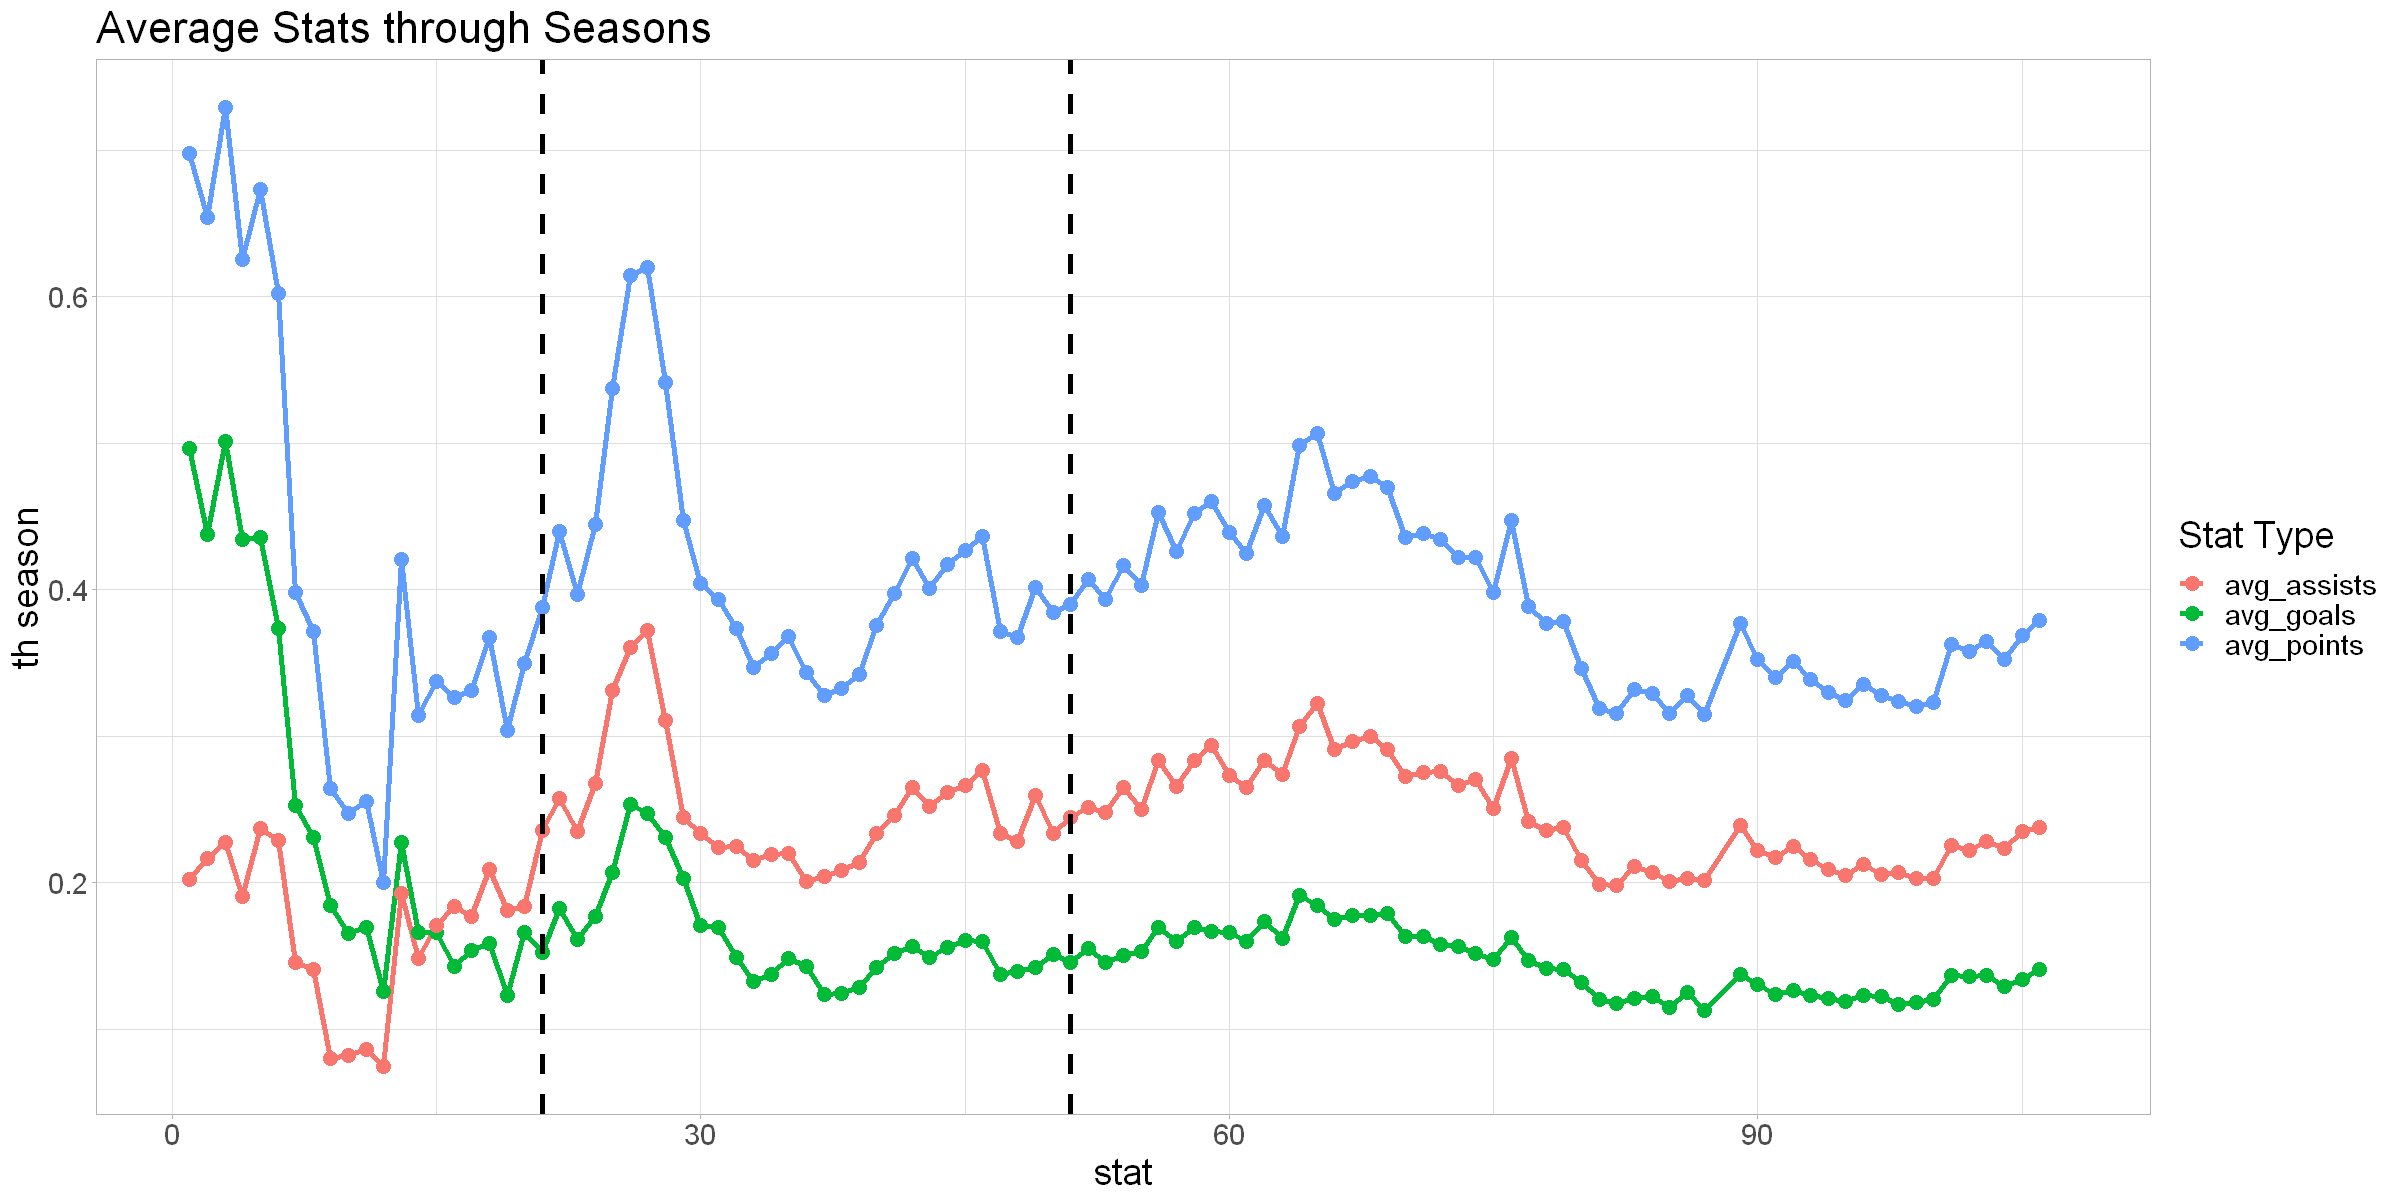

In [138]:
options(repr.plot.width=20, repr.plot.height=10)
player_data %>%
  filter(regular_season==1) %>%
  group_by(season_id) %>%
  summarize(
    avg_goals = mean(avg_g, na.rm=TRUE), 
    avg_points = mean(avg_p, na.rm=TRUE), 
    avg_assists = mean(avg_a, na.rm = TRUE)
    ) %>%
  pivot_longer(!season_id, names_to = "type_stat", values_to = "avg") %>%
  print() %>%
  ggplot(., aes(x = season_id, y = avg, colour = type_stat)) +
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  labs(title= "Average Stats through Seasons", color="Stat Type", y="th season", x="stat") +
  geom_vline(xintercept = 21, size = 1.5, linetype = "dashed") +
  geom_vline(xintercept = 51, size = 1.5, linetype = "dashed") + 
  scale_fill_manual(values = my_colours) +
  def_plot_setup 

The table above, shows average average points, goals and assits per game through NHL history. In early history of the competition, there was a high number of rule changes that dramatically changed average scoring from season to season. Another reason for variability in the first 20 seasons of NHL was a low number of teams and thus also players. The two vertical dashed lines  signify beginning and end of original 6 era.  

### Dominant Player Performances

In the following section, the most dominant performances of players in several different stats (goals, assists, total, points, plus minus for players and save percentage and average goals against for goalkeepers) careerwise and seasonwise are compared. Given that scoring in NHL games varied quite significantly across time given changes in rules and equipment as can be noted in previous graph, the seasonal statistics of individual players are compared not in absolute terms but instead the individual seasonal stats of one player are compared with peofrmances of other players in the same season. Secondly, given to different nature of different positions in hockey, in our case the fact that forwards are expected to score much more than defenders, the stats are also compared separatedly for those two positions. The metric which measures the relative performance is then number of mean absolute deviations from median for a given season. 

#### Distribution of Points Per Game by season

Firstly, we look at the average seasonal points per game. 

Warning message:
"Removed 1135 rows containing non-finite values (`stat_density()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font databas

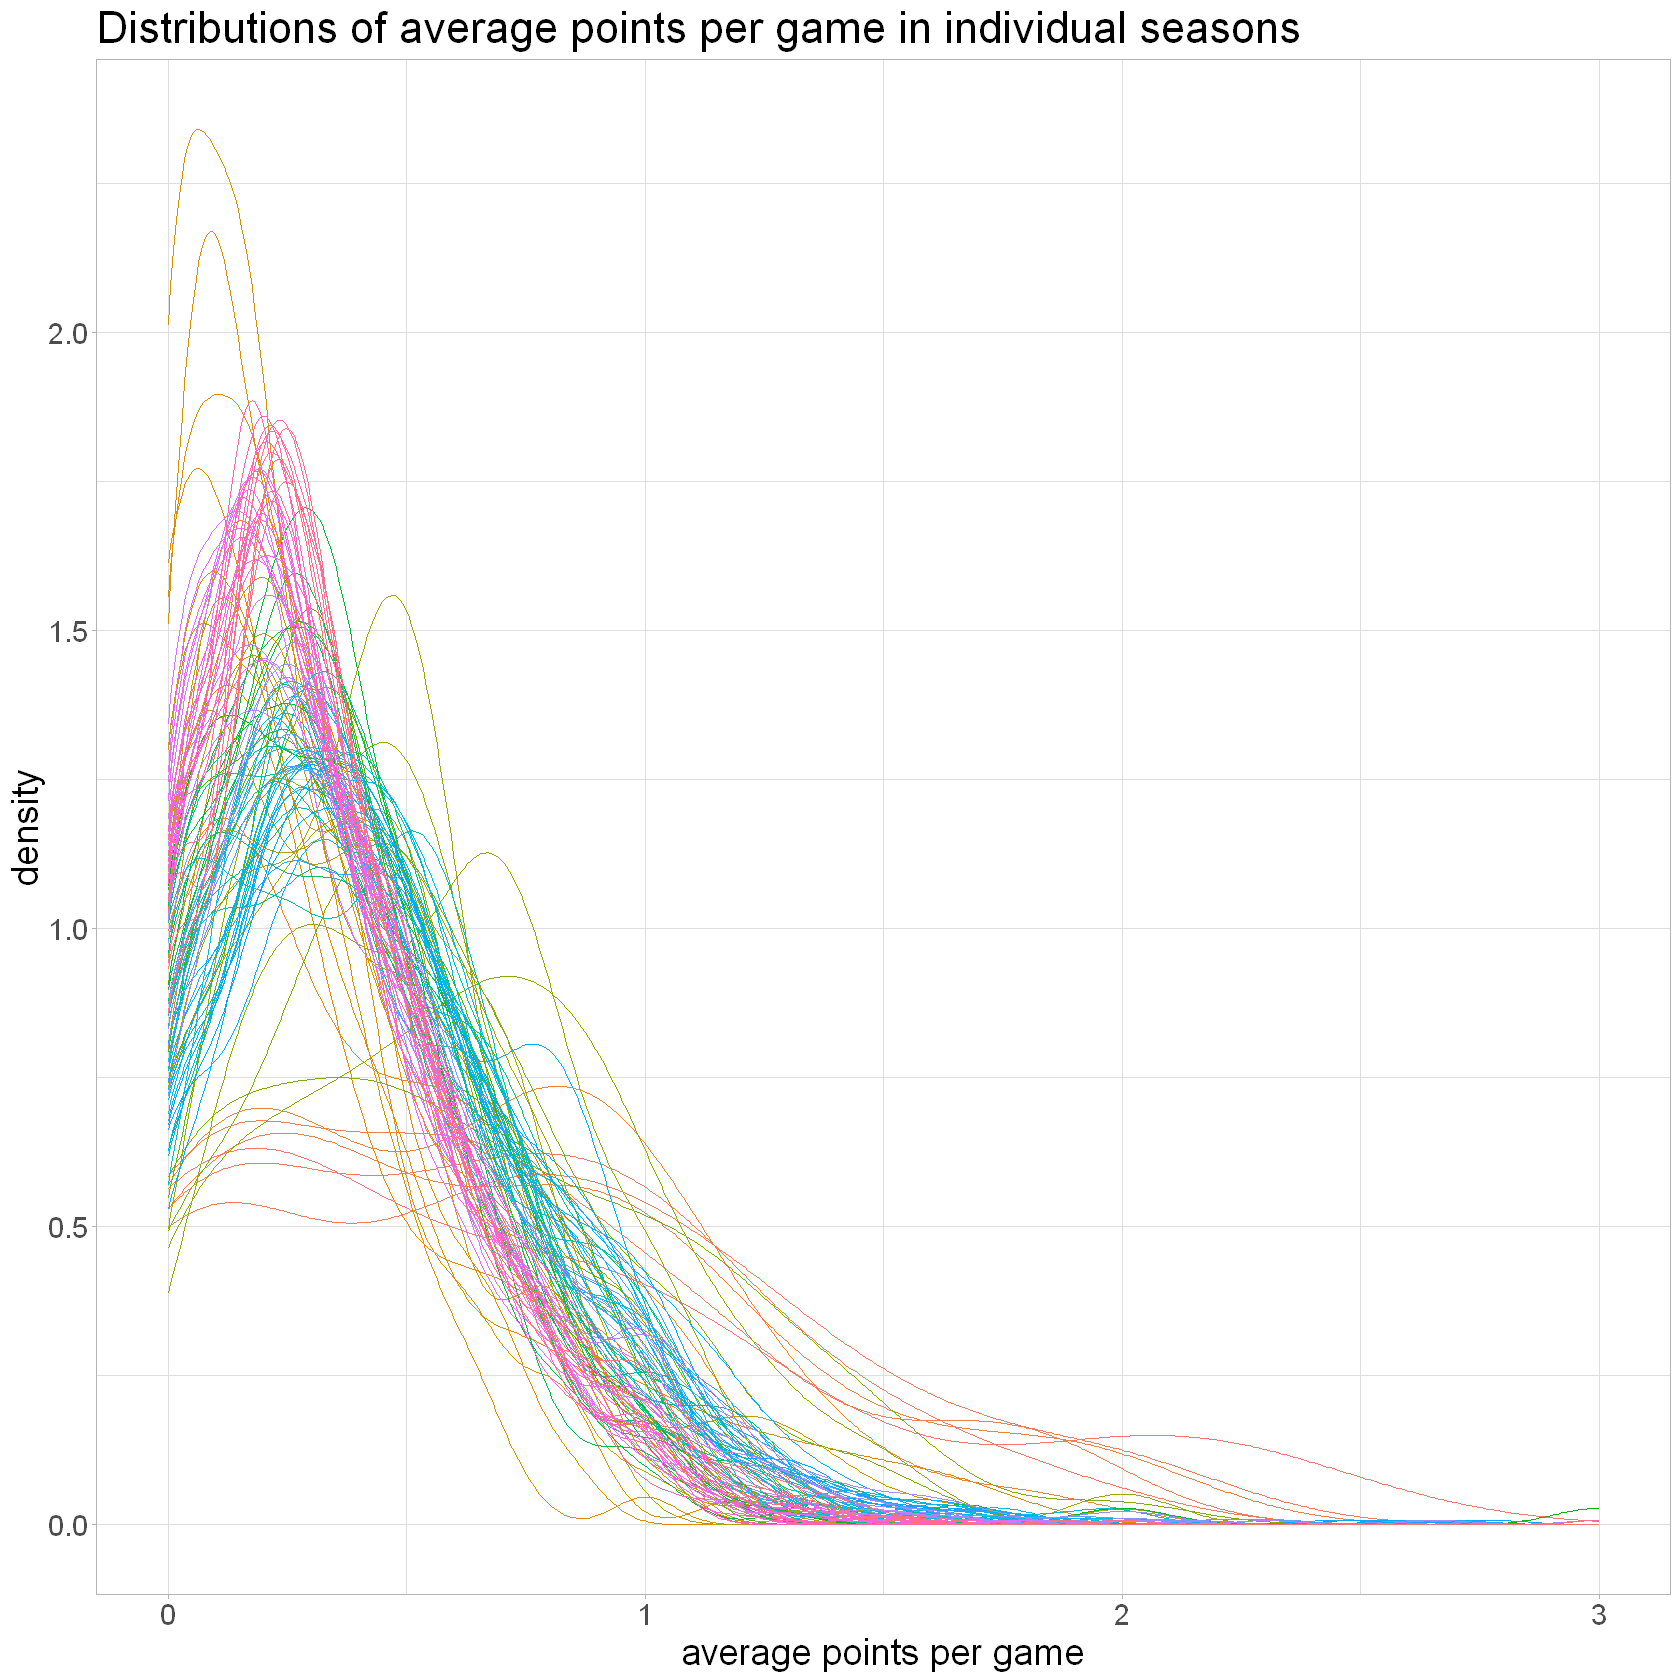

In [17]:
suppressMessages(player_data %>%
  filter(regular_season == 1) %>%
  ggplot(., aes(x = avg_p, colour = season)) + 
  geom_density() + 
  labs(x="average points per game", title="Distributions of average points per game in individual seasons") + 
  def_plot_setup + 
  theme(legend.position = 'none'))

In the graph above, we can see distributions of points per game for all seasons in NHL history. From the graph, it is evident that the distribution is not even close to being symmetric but that it is right skewed instead. Most of the players seem to be concentrated bellow 0.5 points but each season but best players in each season generally achieve twice as high averages. 

#### Points Per Game - Forwards

##### Best Seasons

In [181]:
dominance_p_f <- create_comparative_measure(player_data, "attack", 1, avg_p)
head(dominance_p_f, 20)

u_id,name,season_id,season,handedness,nationality,active,position,regular_season,gp,...,tp,plus_minus,pm,avg_g,avg_p,avg_a,median_games,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9679,Mario Lemieux,76,1992-1993,R,Canada,0,C,1,60,...,160,55,38,1.1500000,2.666667,1.5166667,25.0,0.3344675,0.4755952,6.550925
9678,Wayne Gretzky,69,1985-1986,L,Canada,0,C,1,80,...,215,71,46,0.6500000,2.687500,2.0375000,19.0,0.3363613,0.6018868,6.200514
9678,Wayne Gretzky,68,1984-1985,L,Canada,0,C,1,80,...,208,100,52,0.9125000,2.600000,1.6875000,19.0,0.3333604,0.5887491,6.033263
9678,Wayne Gretzky,67,1983-1984,L,Canada,0,C,1,74,...,205,78,39,1.1756757,2.770270,1.5945946,19.0,0.3695186,0.5767591,5.936132
183442,Connor McDavid,104,2020-2021,L,Canada,1,C,1,56,...,105,21,20,0.5892857,1.875000,1.2857143,23.0,0.2471000,0.4166667,5.901794
9679,Mario Lemieux,79,1995-1996,R,Canada,0,C,1,70,...,161,10,54,0.9857143,2.300000,1.3142857,24.0,0.3183360,0.4444444,5.828921
9678,Wayne Gretzky,65,1981-1982,L,Canada,0,C,1,80,...,212,80,26,1.1500000,2.650000,1.5000000,17.0,0.3619798,0.6388889,5.555865
9678,Wayne Gretzky,66,1982-1983,L,Canada,0,C,1,80,...,196,61,59,0.8875000,2.450000,1.5625000,19.0,0.3403707,0.5844156,5.481037
9679,Mario Lemieux,72,1988-1989,R,Canada,0,C,1,76,...,199,41,100,1.1184211,2.618421,1.5000000,19.0,0.3818818,0.5613097,5.386775


In the table above the best seasons in terms of dominace over their peers in average points per game for forwards can be seen. In order for the player to be included he had to play at least median number of matches in a given season. Unsuprisingly, for everyone faimiliar with hockey history, most of the leading positions are occupied by the "Great One" Wayne Gretzky, altough all time most dominant season according to our metric is held by a different all time great player Mario Lemieux with his performance in 1992-1993 season. In his best season he achieved point per game average six MADs over league median for forwards with 2.6 poitns per game.  Only player that interrupts the top 10  performance in season dominance of these two players is Connor Mccdavid, even though it has to be noted that he achieved this feat in a season shortened by COVID-19 pandemic. 

##### Career Highs

In [20]:
career_p_dominance_f <- create_career_measure(dominance_p_f)
head(career_p_dominance_f, 20)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.400902,13
Wayne Gretzky,4.130183,20
Connor McDavid,3.966680,8
Sidney Crosby,2.987846,17
Peter Forsberg,2.859442,11
Mike Bossy,2.725810,10
Artemi Panarin,2.693575,8
Auston Matthews,2.657353,7
Leon Draisaitl,2.605054,9


Looking at the career averages of seasonal dominance measure we can see similiar picture to table with individual seasonal performances. The same 3 players occupy first 3 positions. Equivalently, there are only included the players that played at least in median number of season, neveretheless,  there is still an overpresentation of players that are not yet retired or at the end of their career thus the weaker performance at the end of their career do not brought their career average down yet. Still, this makes career average of 4.27 of Wayne Gretzky even more impressive given that he played 19 seasons with more than median number of matches.

##### Comparison of Player Careers across Different Eras

In [173]:
player_data %>%
filter(season_id >= 52 & season_id <= 62) %>%
group_by(name) %>%
summarize(g=sum(g), gp=sum(gp), a=sum(a), tp=sum(tp)) %>%
mutate(ppg=tp/gp, gpg=g/tp, apg=a/tp) %>%
arrange(desc(ppg))

name,g,gp,a,tp,ppg,gpg,apg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bobby Orr,272,620,661,933,1.5048387,0.2915327,0.7084673
Phil Esposito,621,940,733,1354,1.4404255,0.4586411,0.5413589
Mike Bossy,130,170,99,229,1.3470588,0.5676856,0.4323144
Guy Lafleur,407,701,529,936,1.3352354,0.4348291,0.5651709
Bryan Trottier,160,351,291,451,1.2849003,0.3547672,0.6452328
Marcel Dionne,338,641,475,813,1.2683307,0.4157442,0.5842558
Bobby Hull,208,325,199,407,1.2523077,0.5110565,0.4889435
Gilbert Perreault,318,722,493,811,1.1232687,0.3921085,0.6078915
Jean Ratelle,394,941,640,1034,1.0988310,0.3810445,0.6189555


Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'helvetica' not foun

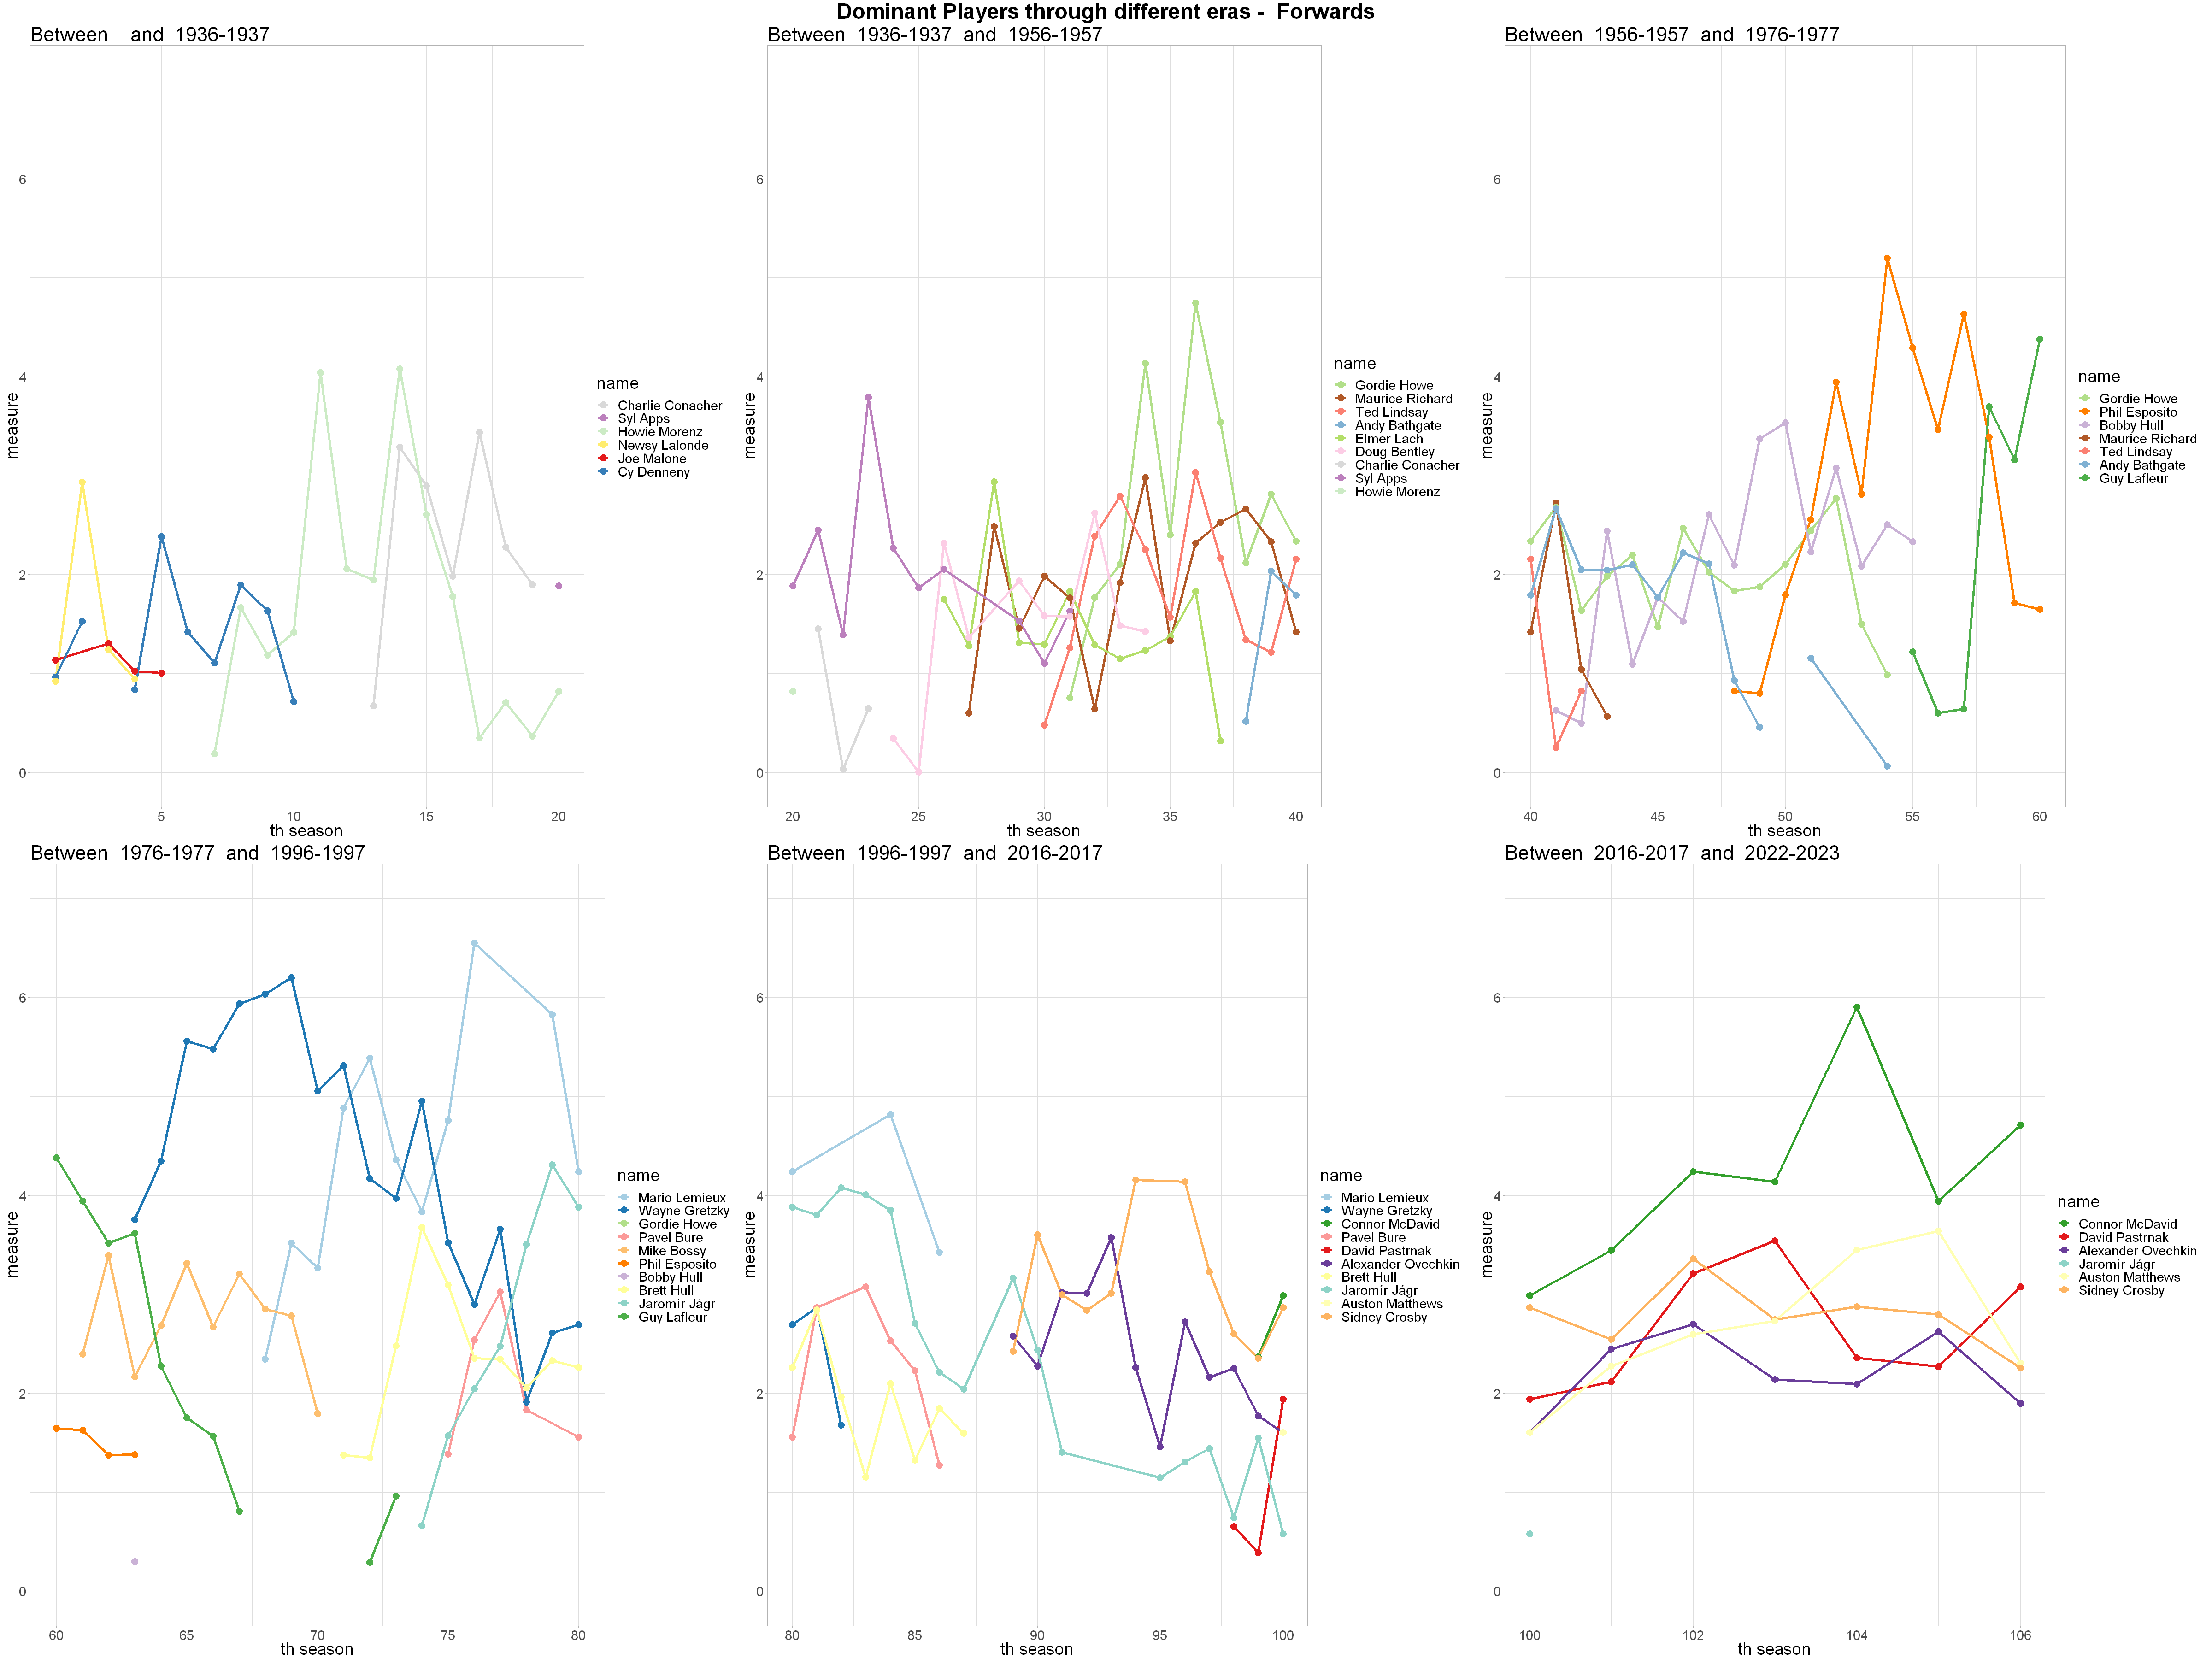

In [168]:
options(repr.plot.width = 40, repr.plot.height = 30)
 season_ids <- c(seq(0, 106,20), 106)
create_era_comparison_plot(df=dominance_p_f, position="forward", stat="ppg", player_list=forward_legends, season_limits=season_ids, title_position="Forwards")


From the look at the player performances across their careers, we can approximately divide them in several tiers. In the highest head and shoulders above others with the exception of Connor Mcdavid, players that spent most of their career over 4 MADs in points per game over the median stat and on their peak they were over 6 MAD over the league median. In the next tier we can include players as 

#### Distribution of Goals per Game in a Season

Warning message:
"Removed 1135 rows containing non-finite values (`stat_density()`)."


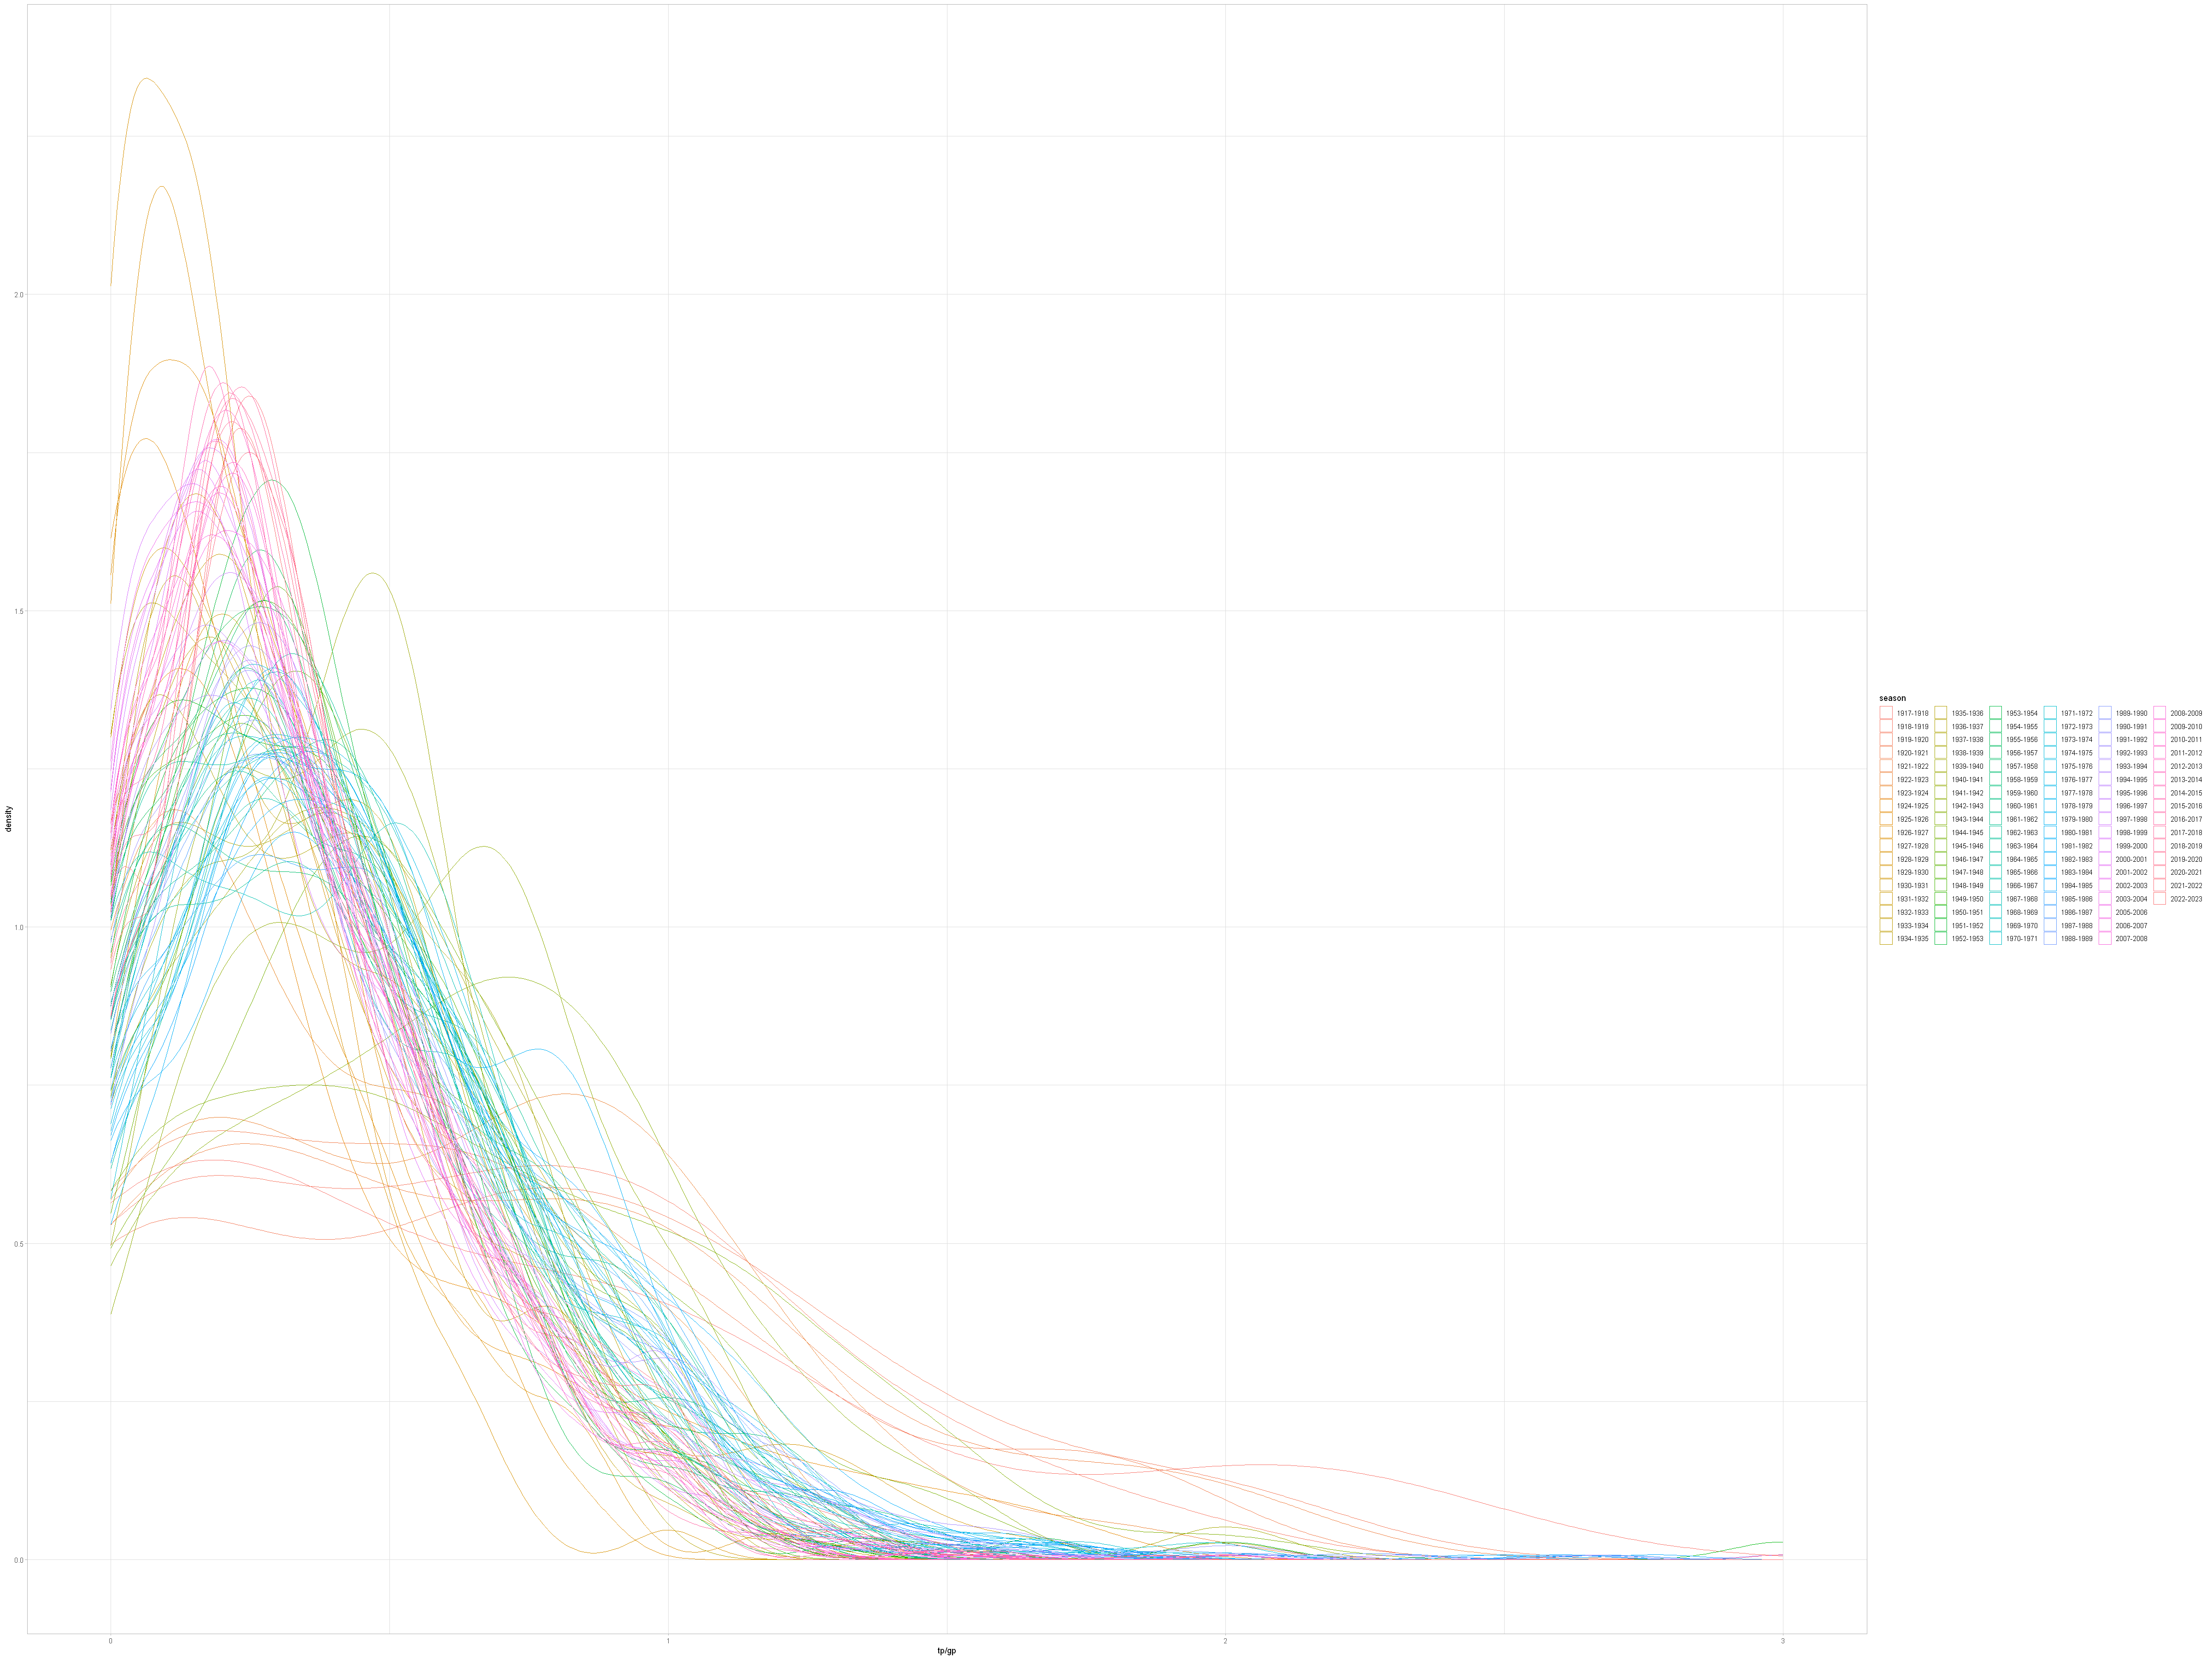

In [153]:
player_data %>%
  filter(regular_season == 1) %>%
  ggplot(., aes(x = tp/gp, colour=season)) + 
  geom_density() + 
  theme_light()

#### Goals Per Game - Forwards

##### Best Seasons

In [177]:
dominance_g_f <- create_comparative_measure(player_data, "attack", 1, avg_g)
head(dominance_g_f, 20)


ERROR: [1m[33mError[39m in `summarize()`:[22m
[1m[22m[36mi[39m In argument: `quant_75 = quantile(...)`.
[36mi[39m In group 1: `season = "1917-1918"`.
[1mCaused by error in `quantile()`:[22m
[33m![39m object 'avg_g' not found


Looking at the most dominant season in regards to goals scored, we can again see the familiar names of Mario Lemieux  and Wayne Gretzky but  the first position is held by a different player  Brett Hull for his performance in 1990-1991 season.  In general, there is much higher variability in top ten in comparison with average point per game table. There are in total 7 different players.

##### Highest Career Averages

In [166]:
career_g_dominance_f <- create_career_measure(dominance_g_f)
head(career_g_dominance_f, 20)

name,measure,n
<chr>,<dbl>,<int>
Mario Lemieux,4.001252,13
Auston Matthews,3.748438,7
Alexander Ovechkin,3.536563,18
Mike Bossy,3.444412,10
Pavel Bure,3.238658,10
Connor McDavid,2.920432,8
Brett Hull,2.910144,17
Steven Stamkos,2.788963,14
Bobby Hull,2.653791,16


We can see that as in the case of points per game the measure is affected by presence of players which are still at the height of their career and their average measure value is still not watered down by the weaker performances in their later years. Nevertheless on the first position is retired player, no other than Mario Lemieux, followed by 

##### Best Players Carreer Comparison

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

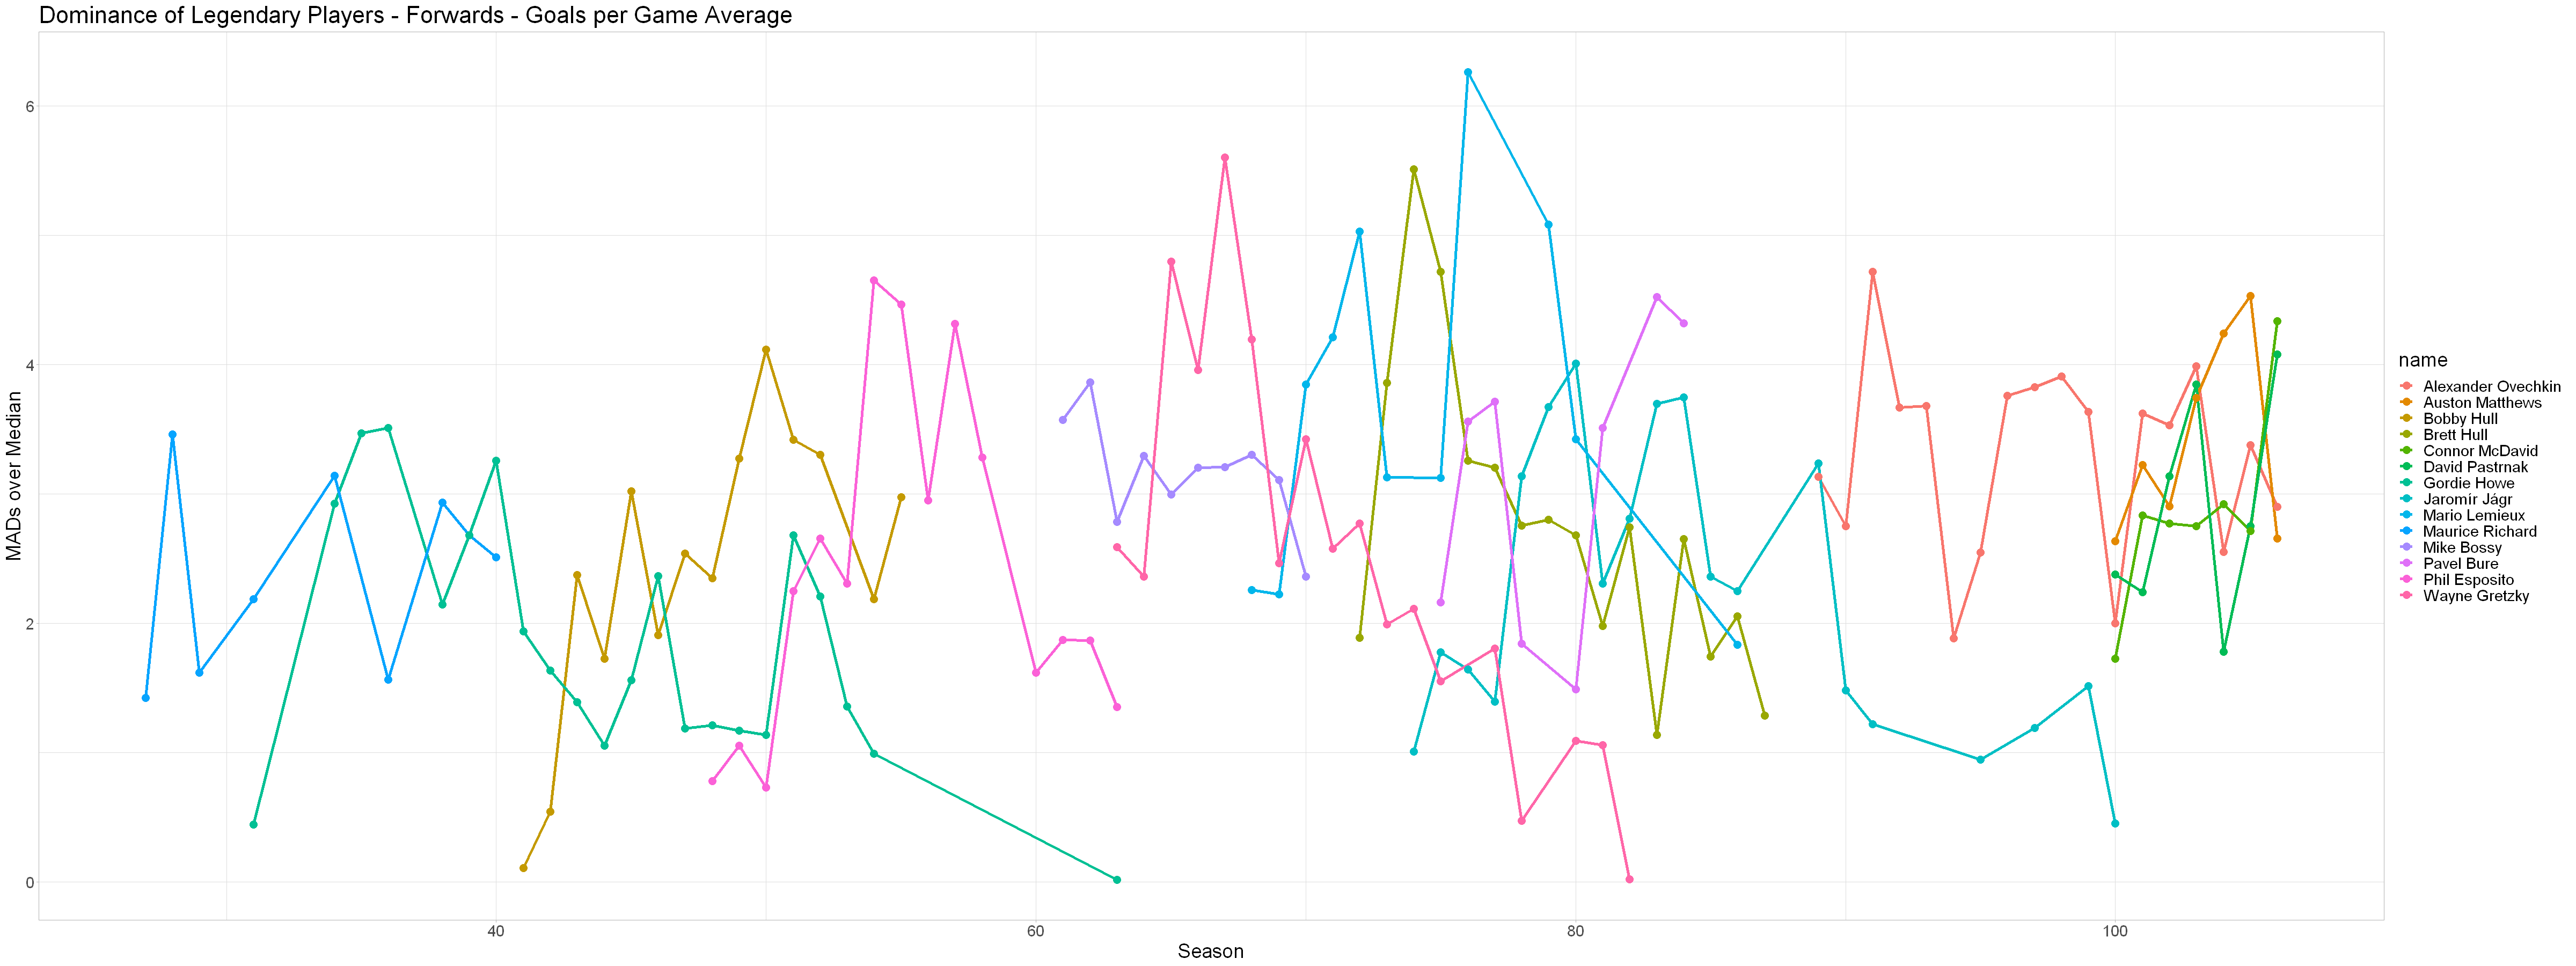

In [90]:
options(repr.plot.width = 40, repr.plot.height = 15)
forward_legends <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Pavel Bure", 
"David Pastrnak", "Mike Bossy", "Phil Esposito", "Bobby Hull", "Alexander Ovechkin", "Brett Hull", "Maurice Richard", 
"Jaromír Jágr", "Auston Matthews")
dominance_g_f %>%
  filter(name %in% forward_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title="Dominance of Legendary Players - Forwards - Goals per Game Average", 
    y="MADs over Median", 
    x="Season"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4)  + 
  def_plot_setup 

#### Points Per Game - Defenders

##### Best Seasons

In [93]:
dominance_p_d <- create_comparative_measure(player_data, "defense", 1, avg_p)
head(dominance_p_d, 20)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bobby Orr,D,0,74,32,90,122,84,1973-1974,137,Canada,1.648649,0.4324324,0.1684773,0.2500000,60.0,8.301705,57
2,Bobby Orr,D,0,63,29,72,101,56,1972-1973,137,Canada,1.603175,0.4603175,0.1742705,0.2500000,62.5,7.764793,56
3,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.687500,0.5750000,0.1824738,0.2773504,59.0,7.727954,58
4,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.578947,0.4342105,0.1820737,0.2118590,56.0,7.508435,53
5,Bobby Orr,D,0,78,37,102,139,124,1970-1971,137,Canada,1.782051,0.4743590,0.2182182,0.2380952,57.0,7.075286,54
6,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.386364,0.9318182,0.1762178,0.1975610,39.5,6.746212,13
7,Erik Karlsson,D,1,82,25,76,101,-26,2022-2023,55,Sweden,1.231707,0.3048780,0.1520615,0.2307692,46.0,6.582454,106
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.539474,0.4868421,0.2188461,0.2241852,54.5,6.010107,55
9,Cale Makar,D,1,60,17,49,66,16,2022-2023,5137,Canada,1.100000,0.2833333,0.1520615,0.2307692,46.0,5.716309,106


##### Highest Career Averages

In [212]:
career_p_dominance_d <- create_career_measure(dominance_p_d)
head(career_p_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.316375,8
Cale Makar,4.663912,4
Paul Coffey,3.960283,15
Quinn Hughes,3.656036,4
Raymond Bourque,3.495245,21
Erik Karlsson,3.481266,13
Brian Leetch,3.440680,13
Adam Fox,3.433012,4
Al MacInnis,3.364472,17


##### Comaprison of Legendary Players

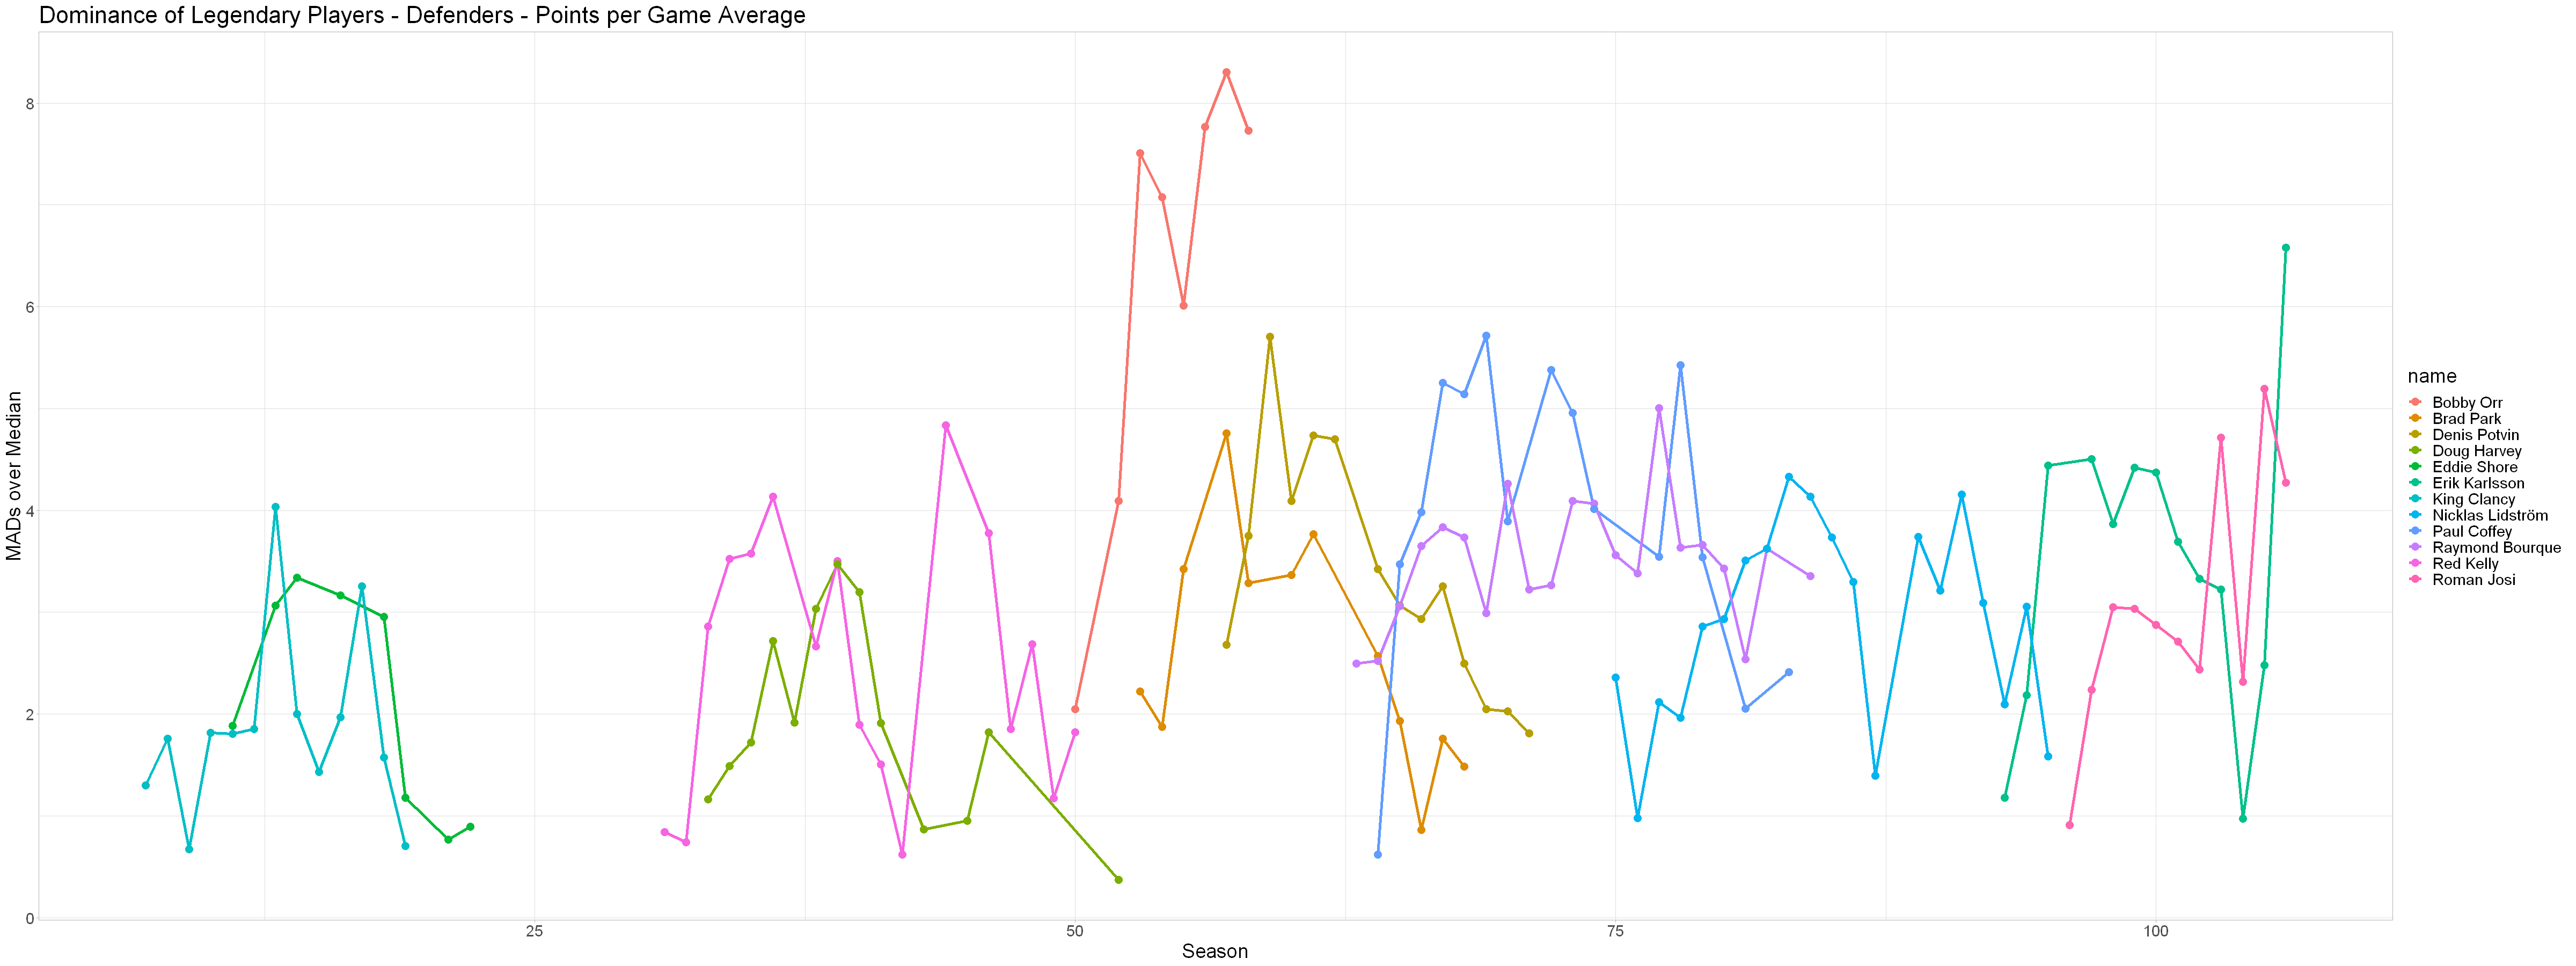

In [227]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Erik Karlsson", "Denis Potvin", "Roman Josi", "Red Kelly", "Nicklas Lidström", "Doug Harvey", "King Clancy", "Eddie Shore", "Brad Park")
dominance_p_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Defenders - Points per Game Average", 
    y = "MADs over Median", 
    x = "Season"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

#### Goals Per Game - Defenders

##### Best Seasons

In [95]:
dominance_g_d <- create_comparative_measure(player_data, "defense", 1, avg_g)
head(dominance_g_d, 20)

rank,name,position,active,gp,g,a,tp,plus_minus,season,team_id,nationality,avg_p,avg_g,mad,median,median_games,measure,season_id
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Doug Mohns,LW/D,0,70,22,27,49,NA,1965-1966,163,Canada,0.7000000,0.3142857,0.02316562,0.01562500,46.0,12.892409,49
2,Dit Clapper,D/F,0,44,41,20,61,NA,1929-1930,137,Canada,1.3863636,0.9318182,0.07990636,0.08001422,39.5,10.660027,13
3,Bobby Orr,D,0,76,33,87,120,54,1969-1970,137,Canada,1.5789474,0.4342105,0.04266696,0.02877847,56.0,9.502249,53
4,Sergei Gonchar,D,0,53,21,10,31,1,1998-1999,39,Russia,0.5849057,0.3962264,0.04061918,0.02739726,46.0,9.080173,82
5,Bobby Orr,D,0,80,46,89,135,80,1974-1975,137,Canada,1.6875000,0.5750000,0.06177500,0.04166667,59.0,8.633482,58
6,Dit Clapper,D/F,0,48,17,8,25,NA,1936-1937,137,Canada,0.5208333,0.3541667,0.03901579,0.02631579,39.0,8.403031,20
7,Mike Green,D,0,68,31,42,73,24,2008-2009,39,Canada,1.0735294,0.4558824,0.05202105,0.03508772,52.0,8.088930,92
8,Bobby Orr,D,0,76,37,80,117,86,1971-1972,137,Canada,1.5394737,0.4868421,0.05816354,0.03923077,54.5,7.695738,55
9,Baldy Northcott,D/LW,0,46,15,14,29,NA,1936-1937,145,Canada,0.6304348,0.3260870,0.03901579,0.02631579,39.0,7.683330,20


##### Highest Career Averages

In [268]:
career_g_dominance_d <- create_career_measure(dominance_g_d)
head(career_g_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Bobby Orr,6.568746,8
Baldy Northcott,3.798623,9
Paul Coffey,3.687214,15
Red Kelly,3.616186,17
Denis Potvin,3.569438,14
Dit Clapper,3.466639,15
Al MacInnis,3.302296,17
Doug Mohns,3.281146,17
Guy Lapointe,3.234358,8


##### Comparison of Legendary Players

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

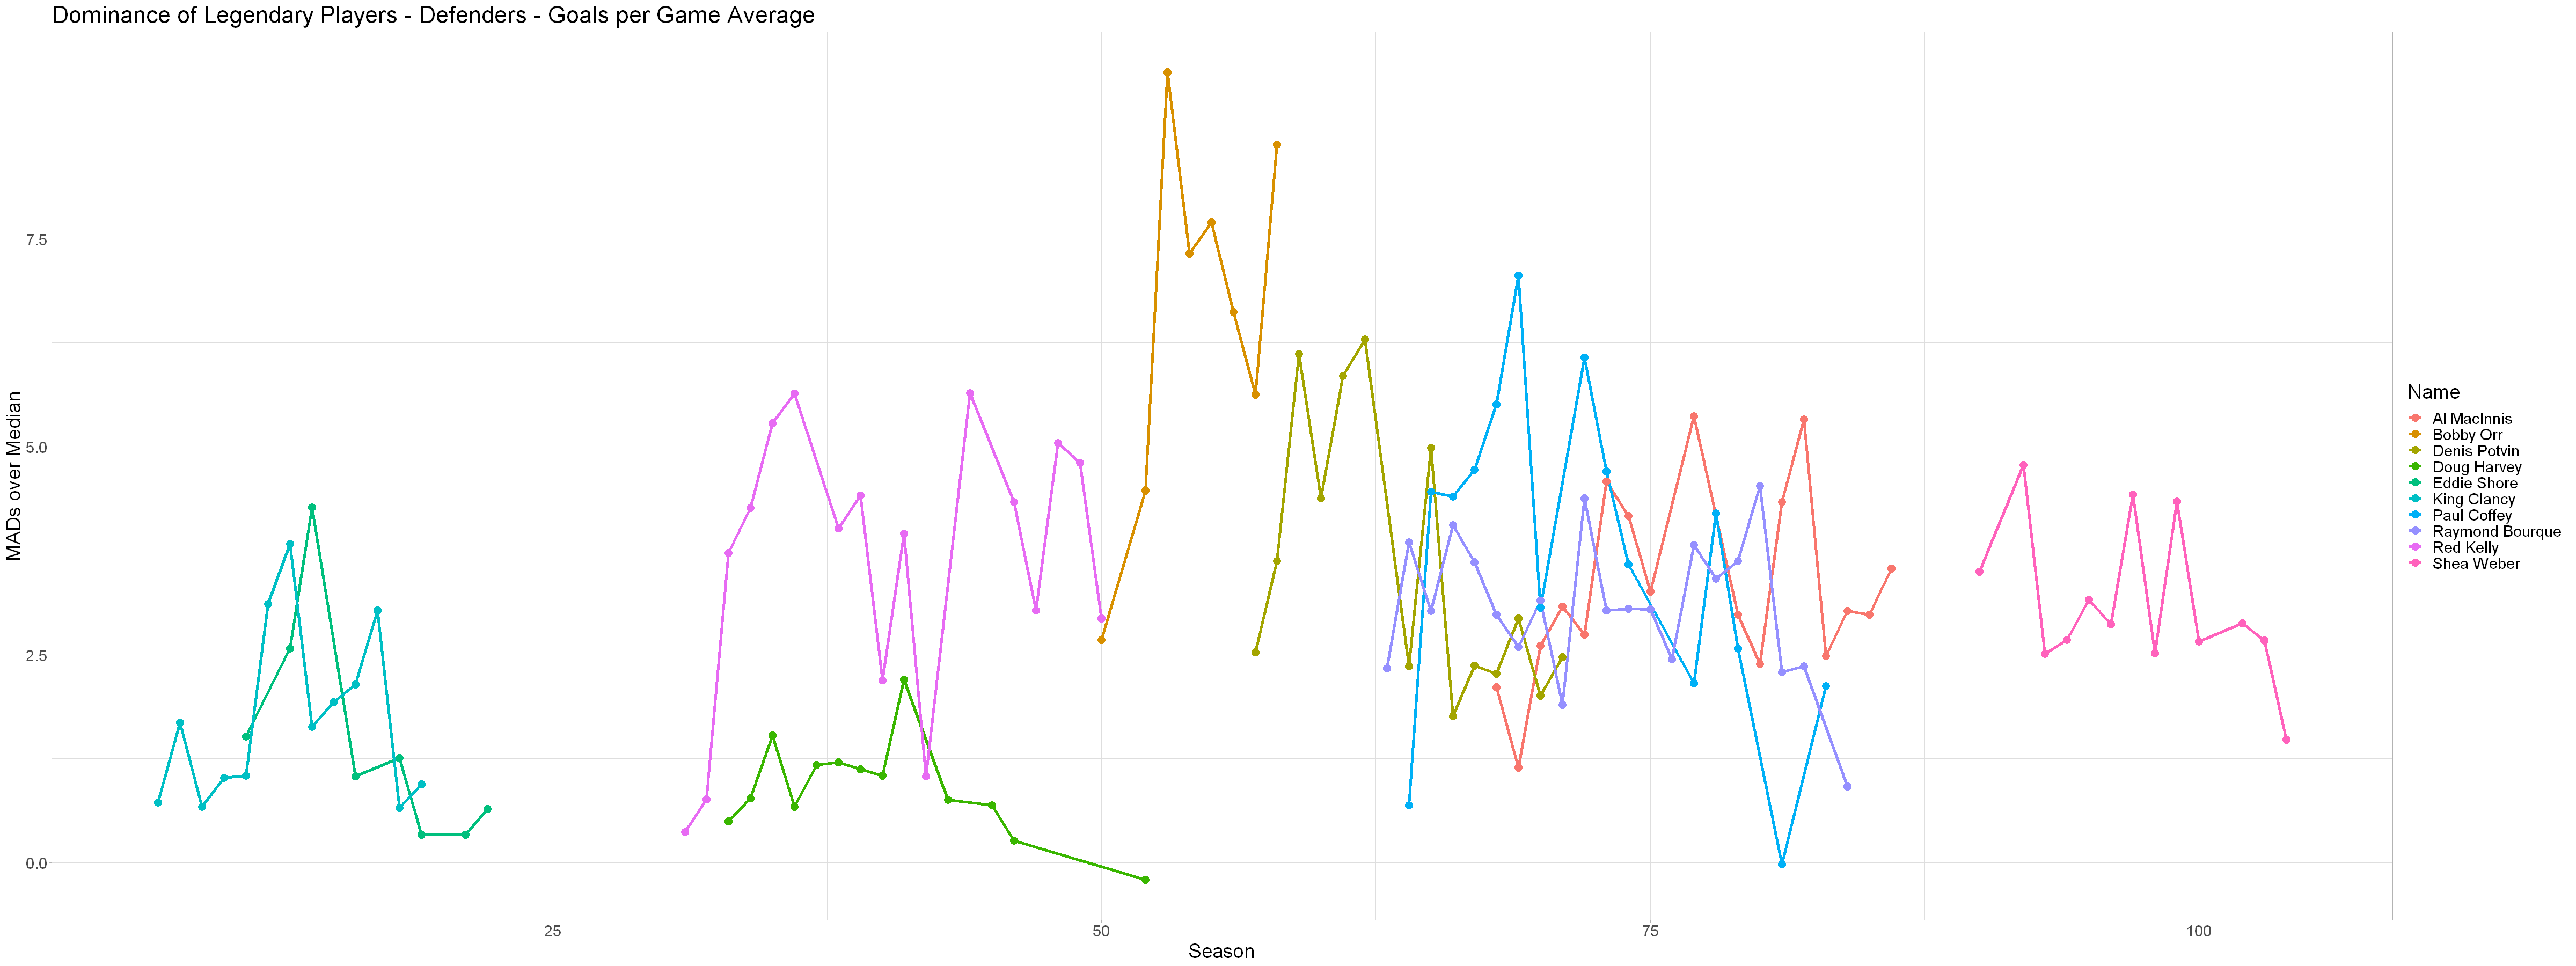

In [274]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Shea Weber", "Denis Potvin", "Al MacInnis", "Red Kelly", "Doug Harvey", "King Clancy", "Eddie Shore")
dominance_g_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Defenders - Goals per Game Average", 
    y = "MADs over Median", 
    x = "Season", 
    colour = "Name"
  ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

#### Plus Minus - Defenders

##### Best Seasons

In [288]:
dominance_ps_d <- create_comparative_measure(player_data, "defense", 1, plus_minus)
head(dominance_ps_d, 10)

Adding missing grouping variables: `u_id`, `handedness`


rank,u_id,handedness,name,position,active,gp,g,a,tp,...,season,nationality,avg_p,avg_g,avg_a,mad,median,median_games,measure,season_id
<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19145,L,Bobby Orr,D,0,78,37,102,139,...,1970-1971,Canada,1.7820513,0.47435897,1.3076923,13.3434,-1,63.0,9.367927,54
2,22126,L,Mark Howe,D,0,77,24,58,82,...,1985-1986,USA,1.0649351,0.31168831,0.7532468,10.3782,-1,54.5,8.286601,69
3,23533,L,Larry Robinson,D,0,77,19,66,85,...,1976-1977,Canada,1.1038961,0.24675325,0.8571429,14.8260,-2,60.0,8.228787,60
4,32217,L,Brad McCrimmon,D,0,80,13,43,56,...,1985-1986,Canada,0.7000000,0.16250000,0.5375000,10.3782,-1,54.5,8.093889,69
5,8538,L,Chris Pronger,D,0,81,9,27,36,...,1997-1998,Canada,0.4444444,0.11111111,0.3333333,5.9304,0,59.5,7.925266,81
6,78144,L,Brian Engblom,D,0,76,4,29,33,...,1981-1982,Canada,0.4342105,0.05263158,0.3815789,10.3782,-1,50.0,7.612110,65
7,21375,L,Scott Stevens,D,0,83,18,60,78,...,1993-1994,Canada,0.9397590,0.21686747,0.7228916,7.4130,-1,59.0,7.284500,77
8,8538,L,Chris Pronger,D,0,79,14,48,62,...,1999-2000,Canada,0.7848101,0.17721519,0.6075949,7.4130,-1,57.0,7.149602,83
9,59575,L,Devon Toews,D,1,66,13,44,57,...,2021-2022,Canada,0.8636364,0.19696970,0.6666667,7.4130,-1,52.0,7.149602,105


##### Highest Career Averages

In [270]:
career_ps_dominance_d <- create_career_measure(dominance_ps_d)
head(career_ps_dominance_d, 10)

name,measure,n
<chr>,<dbl>,<int>
Vladimir Konstantinov,4.155613,6
Mark Howe,3.428807,11
Charlie McAvoy,3.365300,6
Brad McCrimmon,3.293613,16
Larry Robinson,3.288850,19
Nicklas Lidström,3.194276,20
Raymond Bourque,2.973571,21
Matt Grzelcyk,2.891113,6
Craig Muni,2.825367,9


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


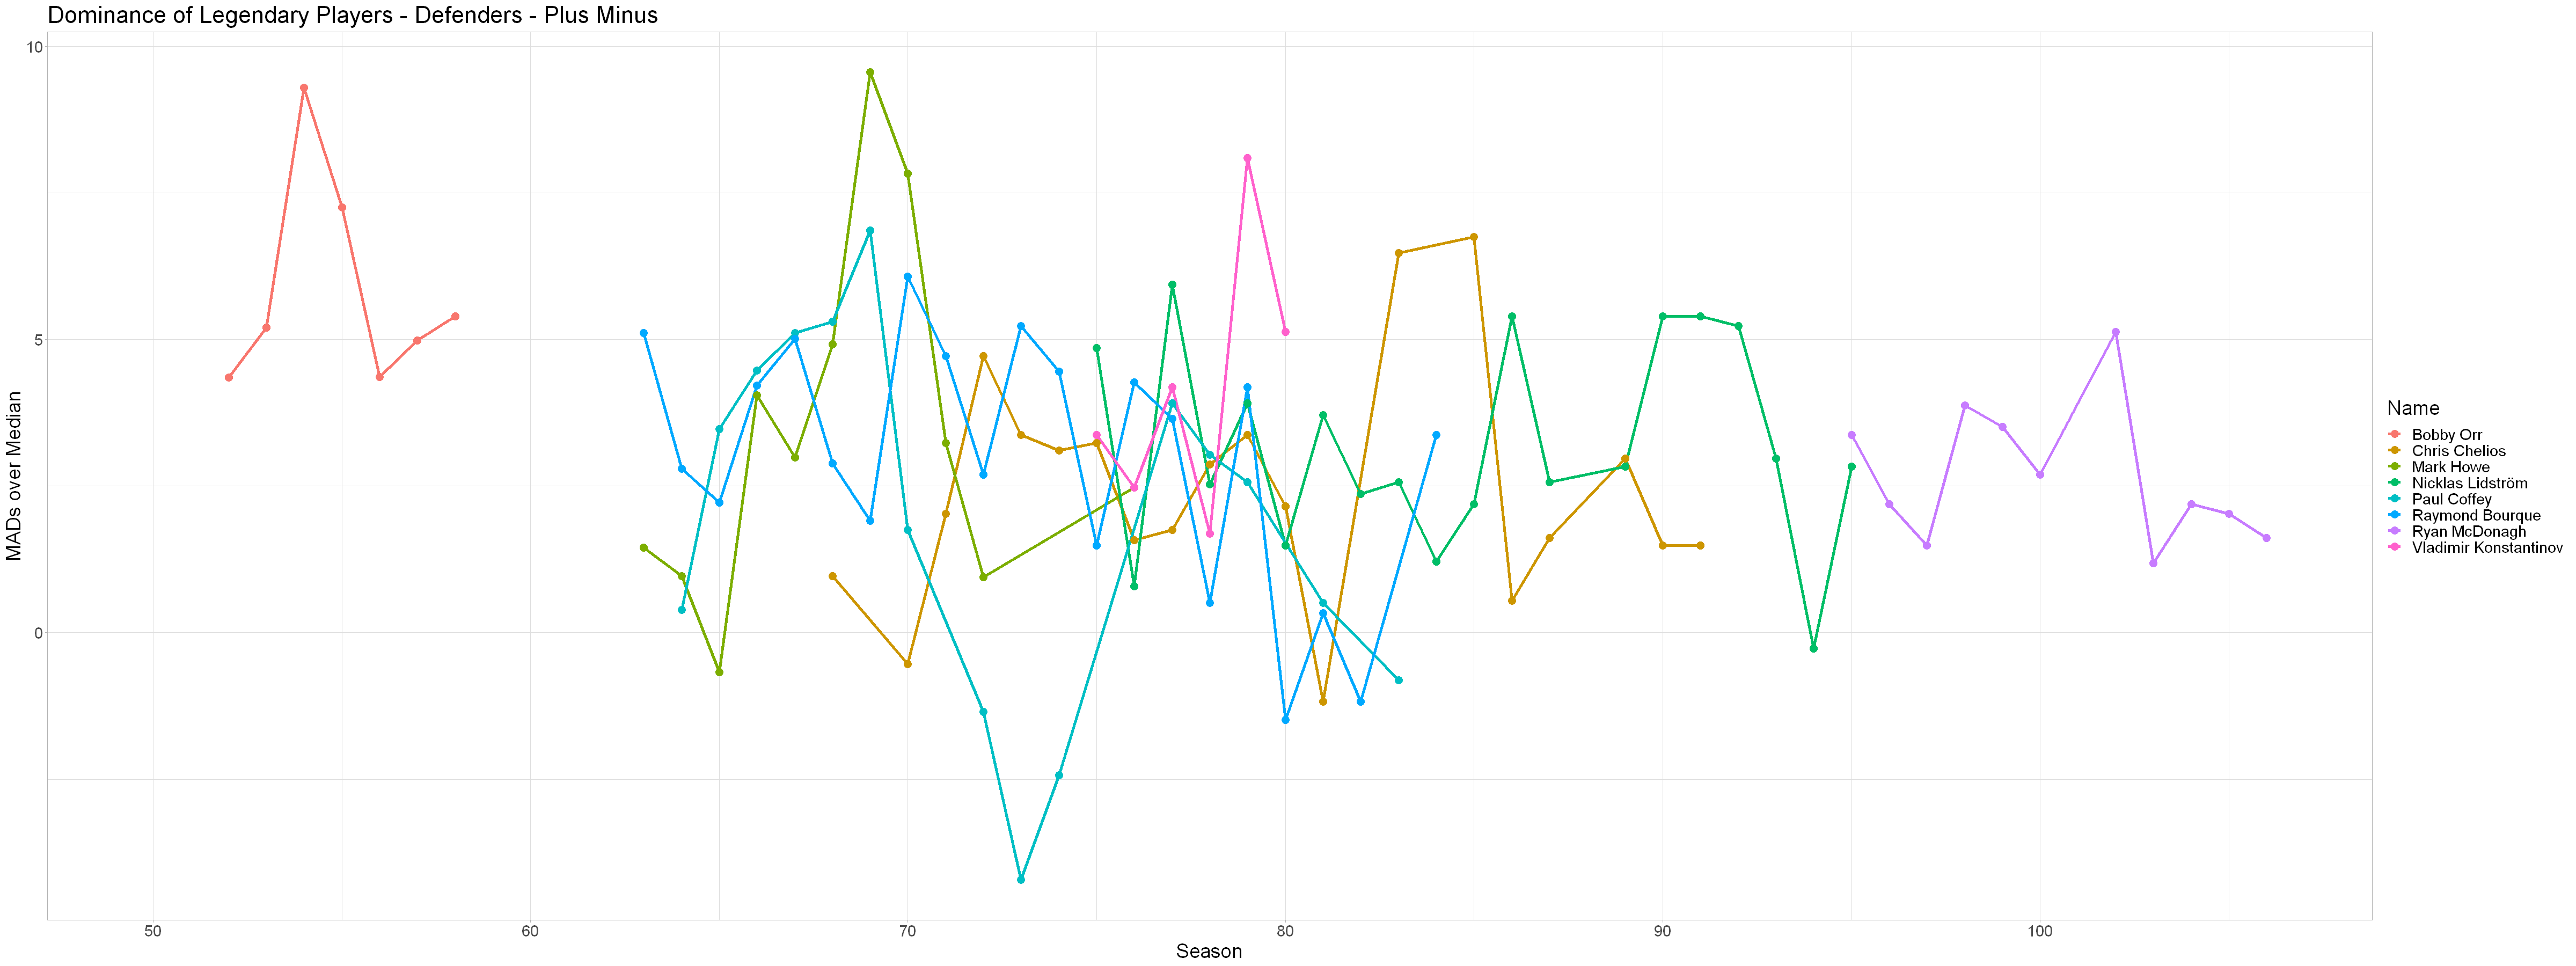

In [225]:
options(repr.plot.width = 40, repr.plot.height = 15)
defense_legends <- c("Bobby Orr", "Paul Coffey", "Raymond Bourque", "Vladimir Konstantinov", "Mark Howe", "Nicklas Lidström", "Chris Chelios", "Ryan McDonagh")
dominance_ps_d %>%
  filter(name %in% defense_legends) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
    labs(
      title = "Dominance of Legendary Players - Defenders - Plus Minus", 
      y = "MADs over Median", 
      x = "Season", 
      colour = "Name"
    ) + 
    geom_line(size = 1.5) + 
    geom_point(size = 4) + 
    def_plot_setup 

### Career Statistical Leaders Through Time

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

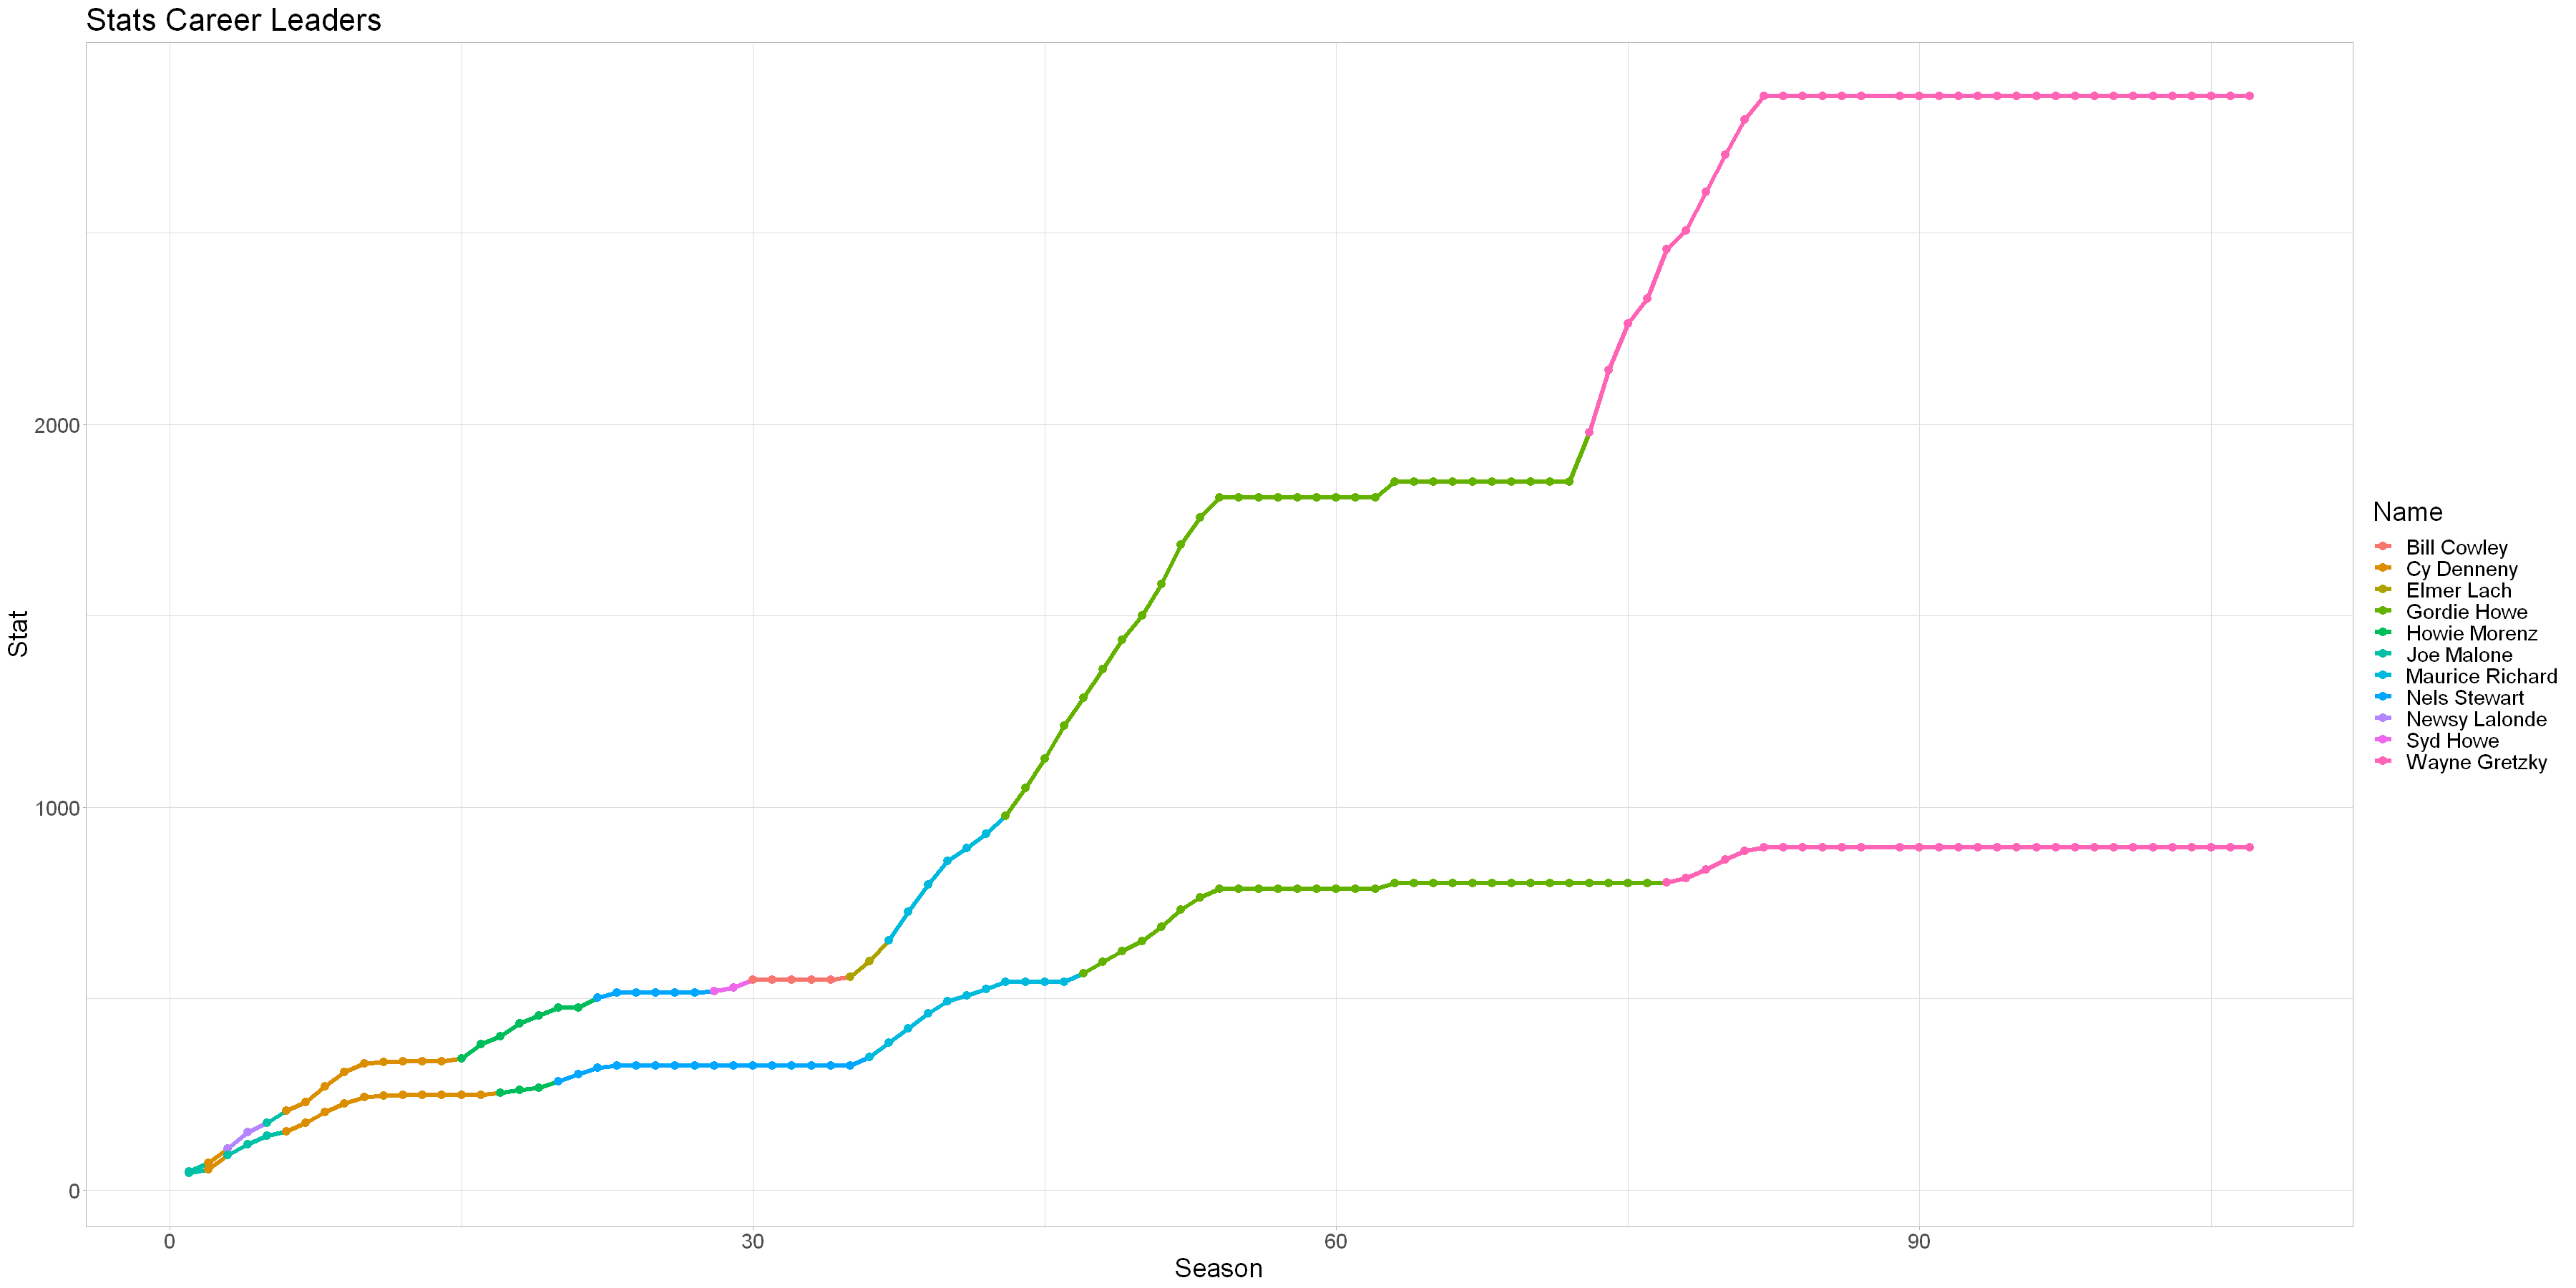

In [254]:
cum_sum <- player_data %>%
  filter(regular_season == 1) %>%
  group_by(name) %>%
  arrange(season_id) %>%
  mutate(cs_tp = cumsum(tp), cs_g = cumsum(g)) 

record_tp_1 <- cum_sum %>%
  group_by(season_id) %>%
  summarize(record_tp = max(cs_tp, na.rm=TRUE)) %>%
  left_join(
    cum_sum_tp, 
    by = join_by(record_tp == cs_tp, season_id == season_id)
    ) %>%
  select(season_id, name, record_tp, tp)

record_g <- cum_sum %>%
  group_by(season_id) %>%
  summarize(record_g = max(cs_g, na.rm = TRUE)) %>%
  left_join(cum_sum, by = join_by(record_g == cs_g, season_id == season_id)) %>%
  select(season_id, name, record_g, g)

for (ind in 2:nrow(record_tp_1)) {
  if (record_tp_1[ind - 1, 3] > record_tp_1[ind, 3]) {
    record_tp_1[ind, 3] <- record_tp_1[ind - 1, 3]
    record_tp_1[ind, 2] <- record_tp_1[ind - 1, 2]
  }
}
for (ind in 2:nrow(record_g)){
  if (record_g[ind - 1, 3] > record_g[ind, 3]) {
    record_g[ind, 3] <- record_g[ind - 1, 3]
    record_g[ind, 2] <- record_g[ind - 1, 2]
  }
}

record_all <- record_tp_1 %>%
  left_join(record_g, by = "season_id")

record_all %>%
  ggplot(., aes(x = season_id, y = record_tp, group = 1, colour = name.x))+
  geom_line(size = 1.75) + 
  geom_point(size = 3, aes(x = season_id, y = record_tp, colour = name.x)) + 
  geom_line(aes(x = season_id, y = record_g, group = 1, colour = name.y), size = 1.75) + 
  geom_point(size = 3, aes(x = season_id, y = record_g, colour = name.y)) + 
  def_plot_setup +
  labs(title = "Stats Career Leaders", x = "Season", y = "Stat", colour = "Name") 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

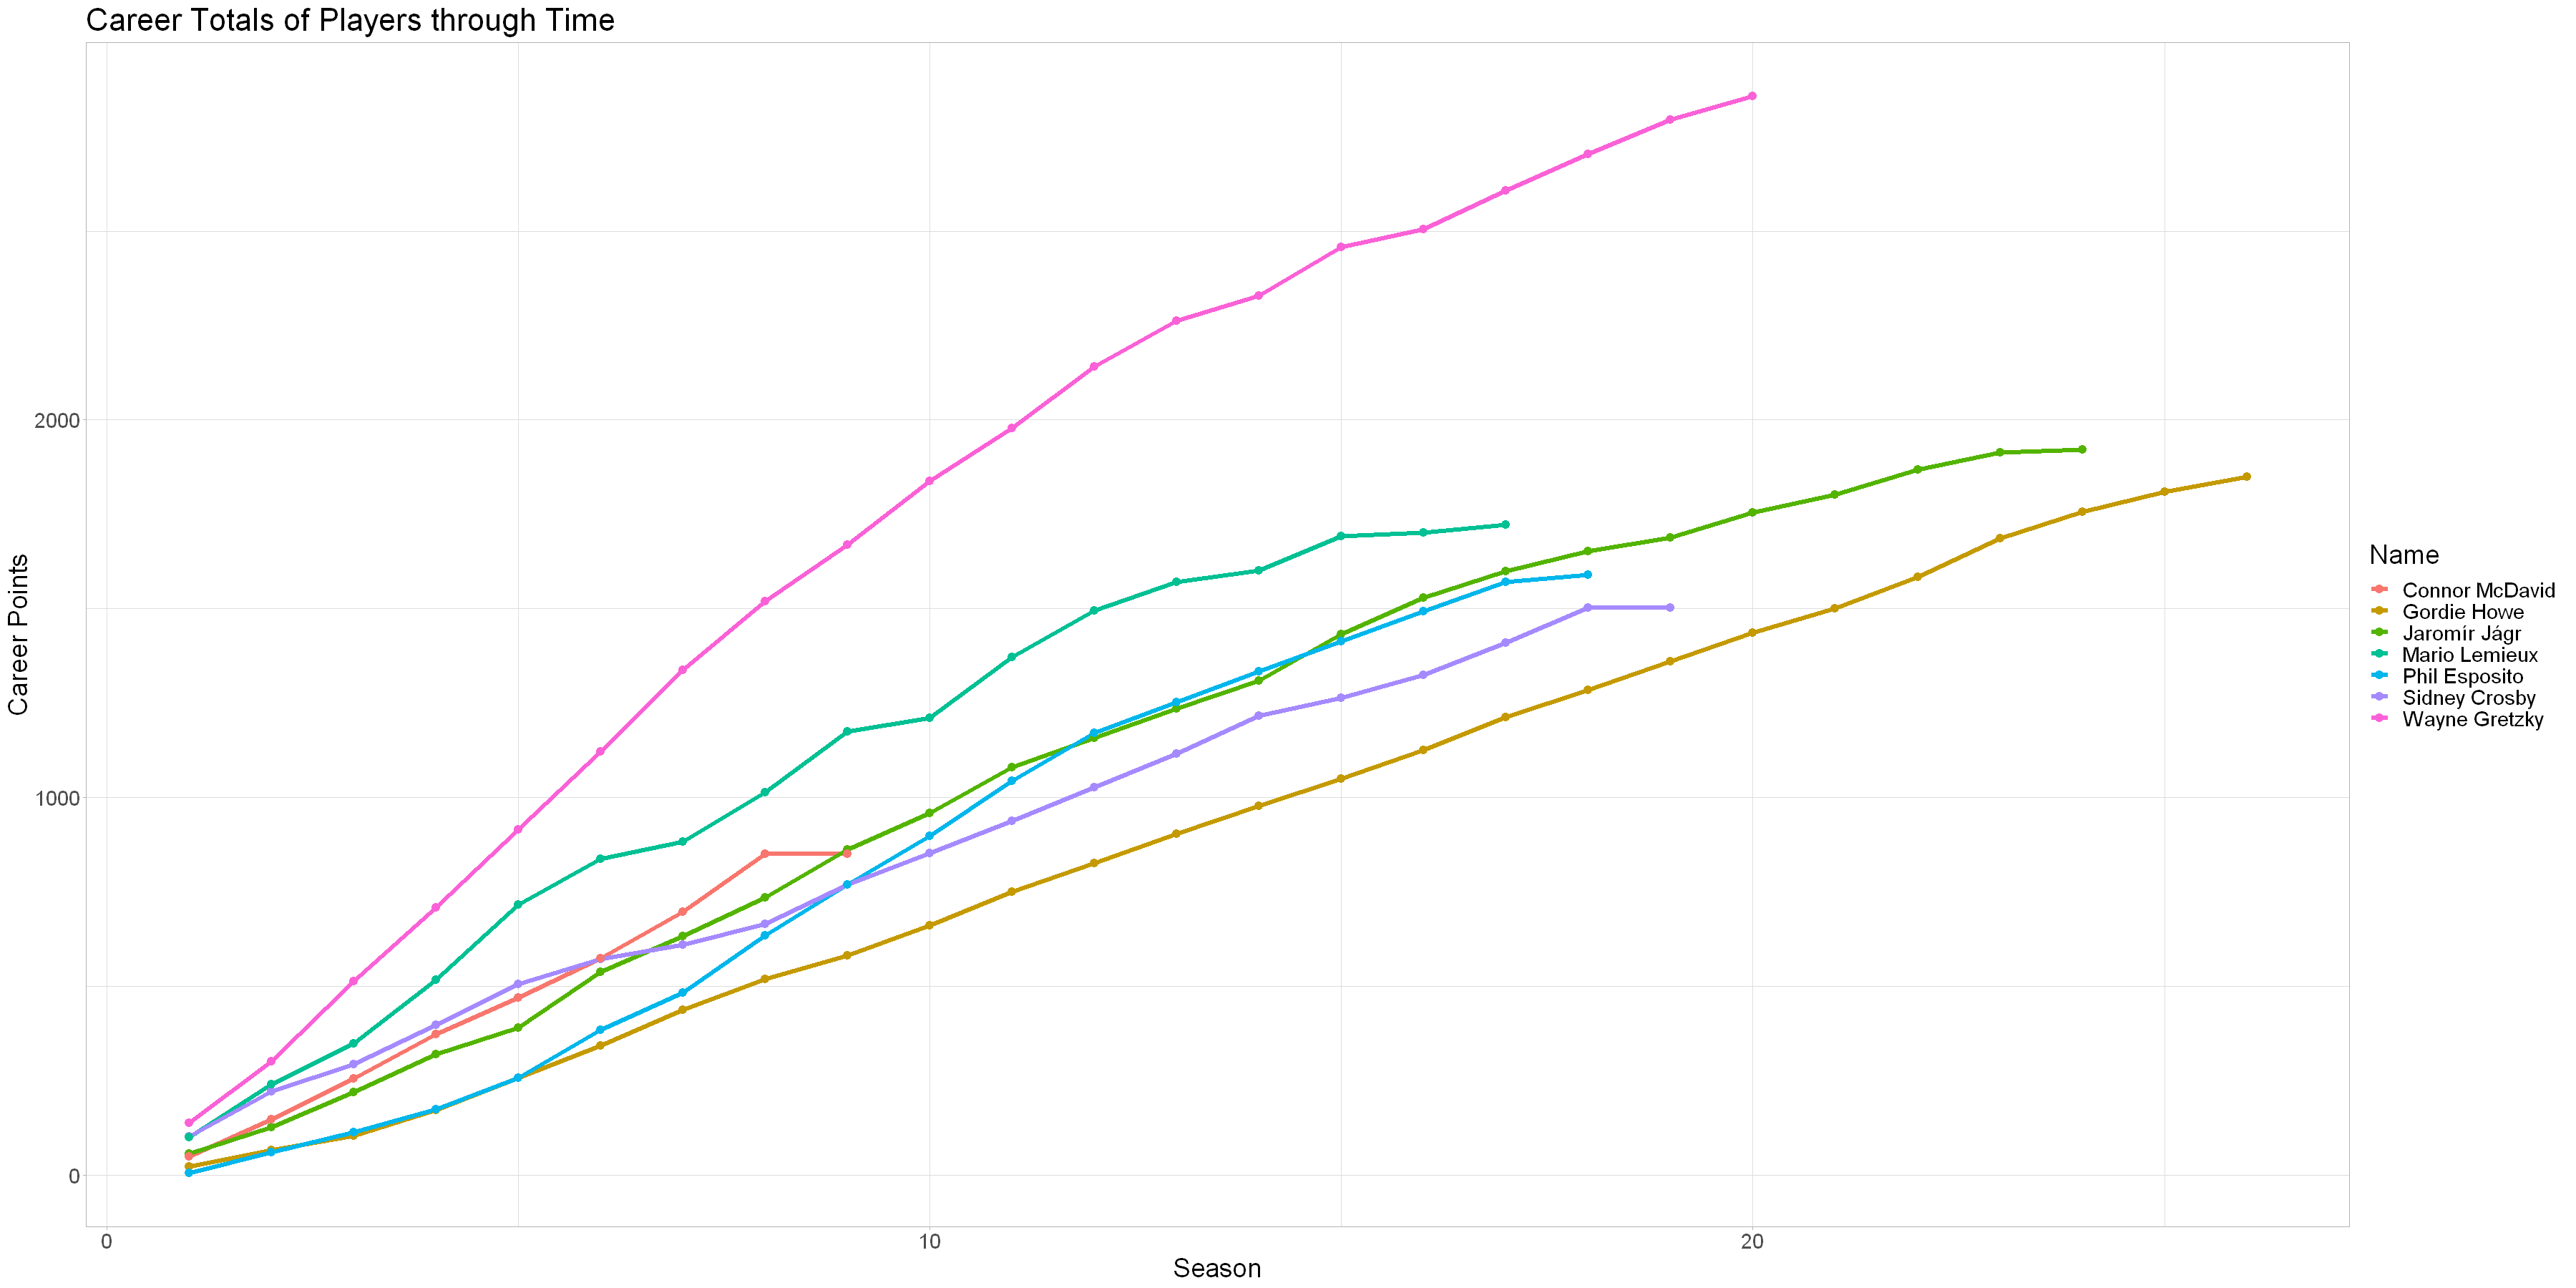

In [273]:
players_include <- c("Mario Lemieux", "Wayne Gretzky", "Gordie Howe", "Connor McDavid", "Jaromír Jágr", "Sidney Crosby", "Phil Esposito")
player_data %>%
  filter(regular_season == 1) %>%
  group_by(name) %>%
  mutate(season_player = row_number(season_id)) %>%
  group_by(name) %>%
  mutate(cum_tp = cumsum(tp)) %>%
  filter(name %in% players_include) %>%
ggplot(., aes(x = season_player, y = cum_tp, colour = name)) + 
  geom_line(size = 1.75) + 
  geom_point(size = 3) + 
  def_plot_setup +
  labs(
    title = "Career Totals of Players through Time", 
    x = "Season", 
    y = "Career Points", 
    colour ="Name"
  )

## Goalkeepers

### Save Percentage

In [180]:
dominance_svp <- create_comparative_measure(goalie_data, "goalie", 1, svp)
dominance_svp %>%
filter(season_id > 95)

u_id,name,season_id,season,catches,nationality,active,position,regular_season,gp,...,w,l,t,toi,gaa,svp,median_games,mad,median,measure
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33246,Cam Talbot,97,2013-2014,L,Canada,1,G,1,21,...,12,6,1,1211,1.5714,0.9411,20.0,0.01067472,0.91320,2.613652
38007,Andrew Hammond,98,2014-2015,L,Canada,0,G,1,24,...,20,1,2,1411,1.7500,0.9406,17.5,0.01022994,0.91410,2.590436
19760,Linus Ullmark,106,2022-2023,L,Sweden,1,G,1,49,...,40,6,1,2883,1.8571,0.9375,19.0,0.01438122,0.90210,2.461544
11797,Ben Bishop,102,2018-2019,L,USA,0,G,1,46,...,27,15,2,2637,1.8913,0.9342,21.0,0.00934038,0.91170,2.408896
135425,Alex Nedeljkovic,104,2020-2021,L,USA,1,G,1,23,...,15,5,3,1392,1.9130,0.9321,14.5,0.01104537,0.90700,2.272445
9066,Craig Anderson,96,2012-2013,L,USA,0,G,1,24,...,12,9,2,1421,1.6667,0.9409,14.0,0.01430709,0.91025,2.142294
195577,Igor Shestyorkin,105,2021-2022,L,Russia,1,G,1,53,...,36,13,4,3071,2.0000,0.9346,12.0,0.01275036,0.90750,2.125430
11433,Curtis McElhinney,101,2017-2018,L,Canada,0,G,1,18,...,11,5,1,979,1.9444,0.9337,17.5,0.01000755,0.91245,2.123397
9308,Semyon Varlamov,104,2020-2021,L,Russia,1,G,1,36,...,19,11,4,2117,2.0000,0.9294,14.5,0.01104537,0.90700,2.027999


#### Carrer Highs

In [340]:
career_dominance_svp <- create_career_measure(dominance_svp)
career_dominance_svp <- career_dominance_svp %>%
filter(n >= median(n))
head(career_dominance_svp, 20)

name,measure,n
<chr>,<dbl>,<int>
Dominik Hasek,1.4642589,14
Patrick Roy,1.2694727,18
Tony Esposito,1.0619151,16
Jacques Plante,0.9262237,17
Tuukka Rask,0.9121168,12
Johnny Bower,0.9021450,12
Chico Resch,0.8869732,13
Bernie Parent,0.8592105,12
Roberto Luongo,0.6772366,19


Warning message:
"Removed 3 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot

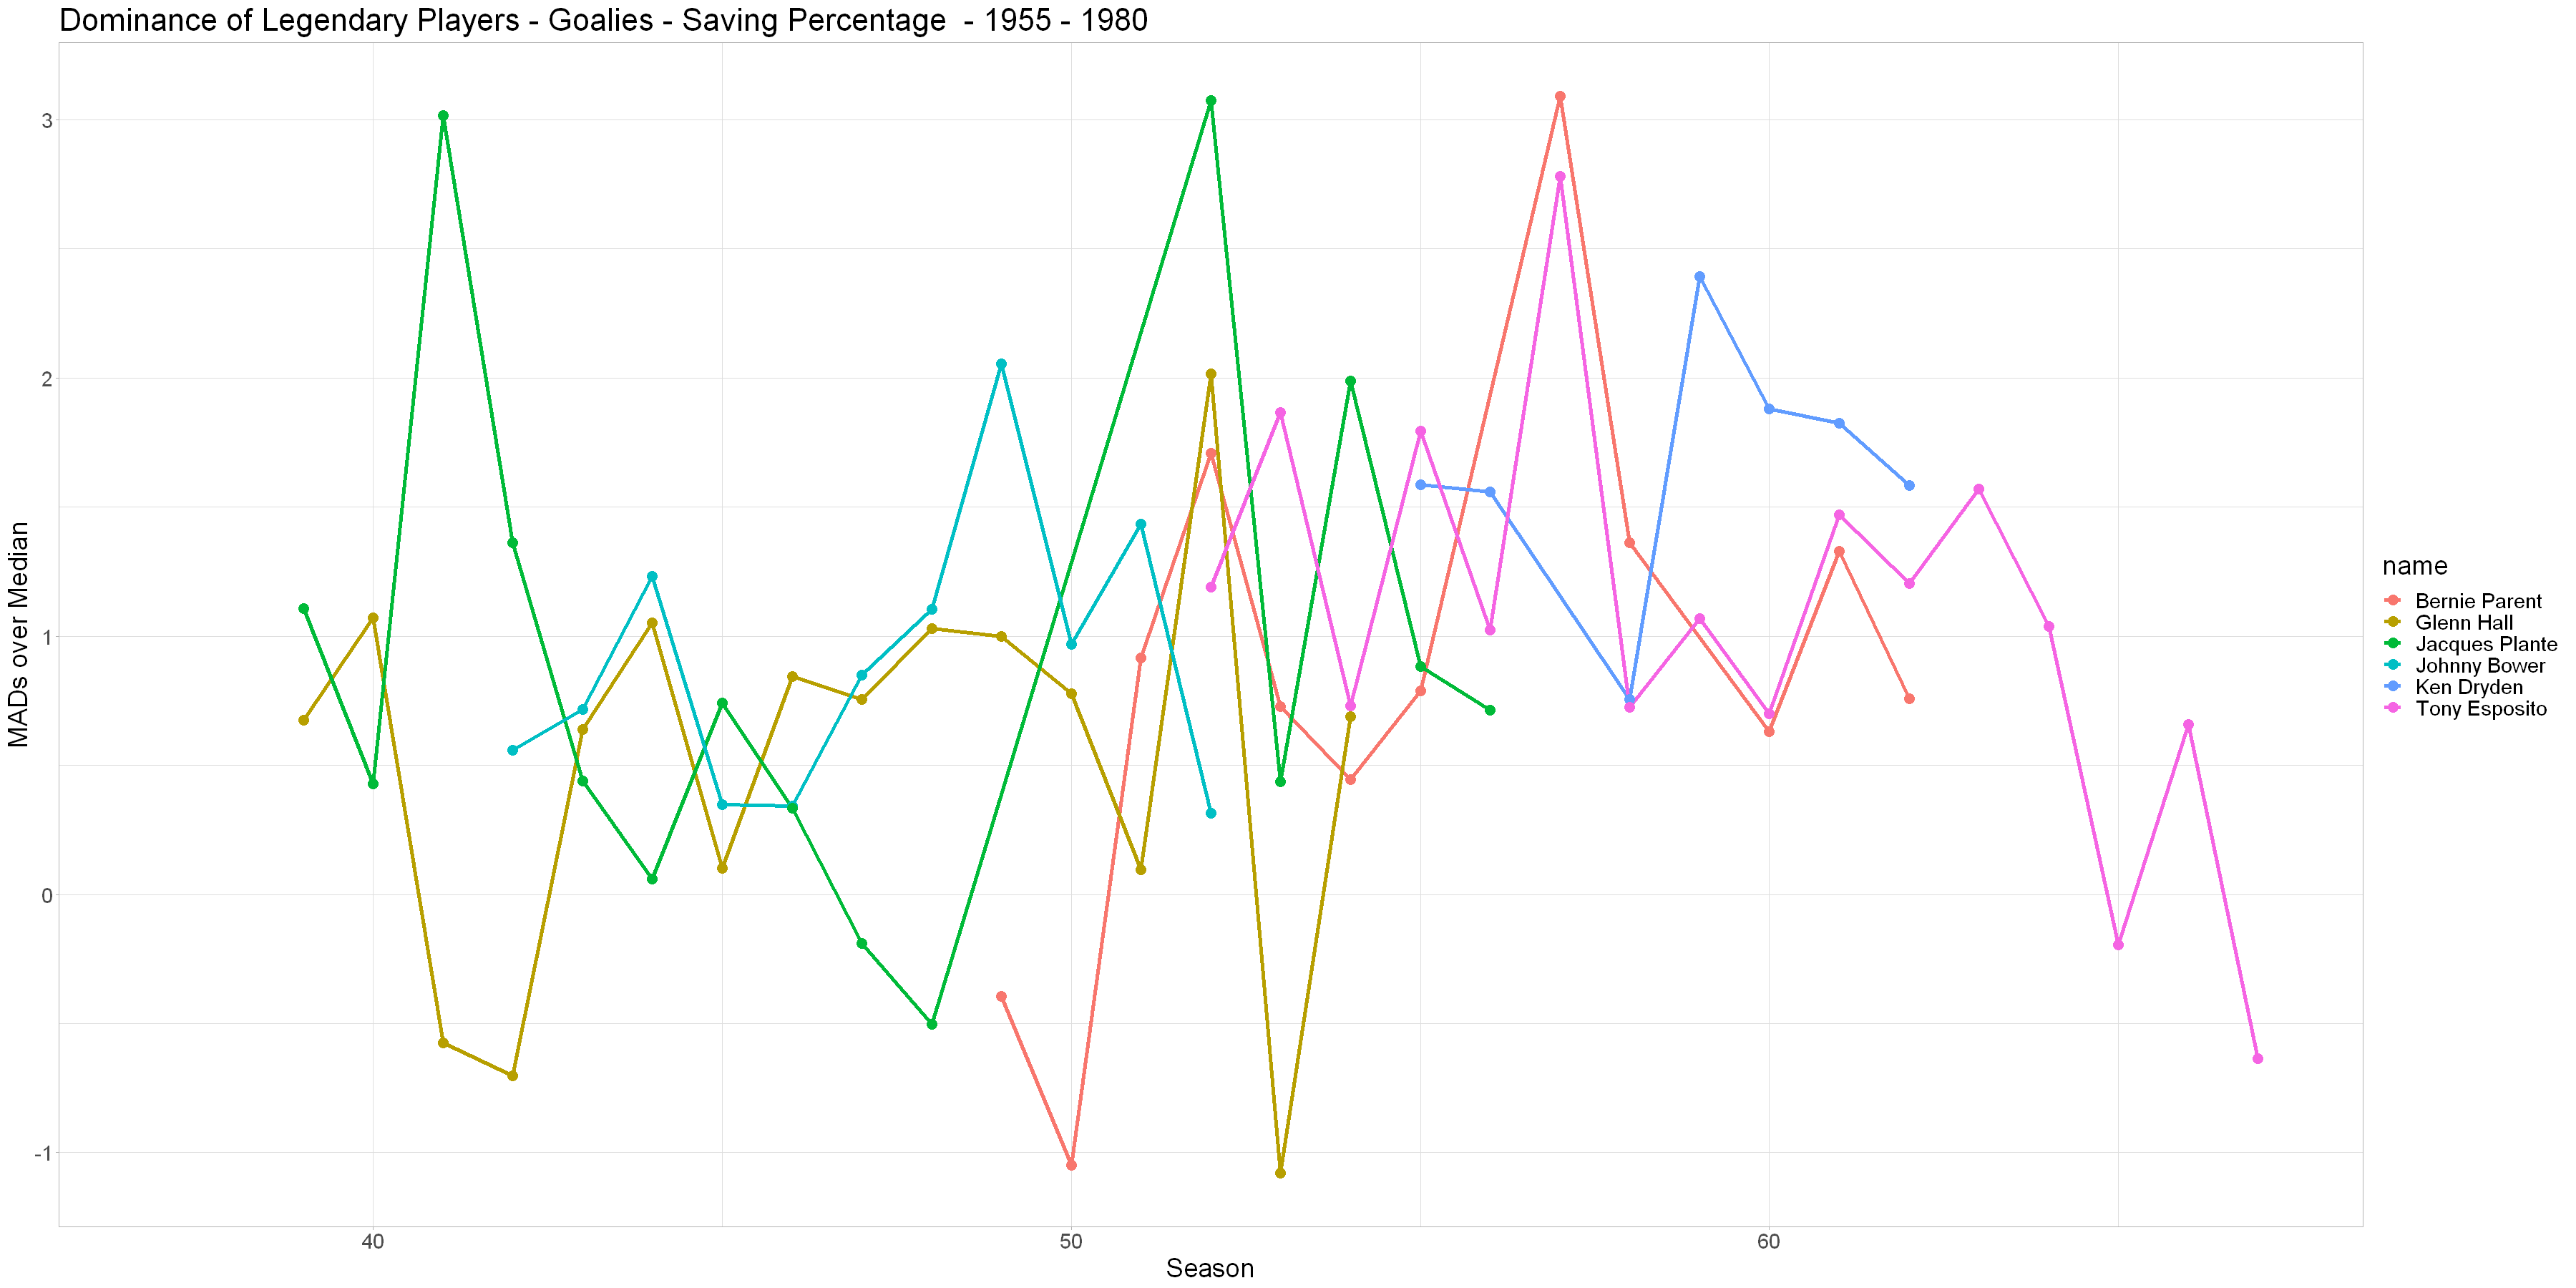

In [352]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id < 68) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1955 - 1980", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

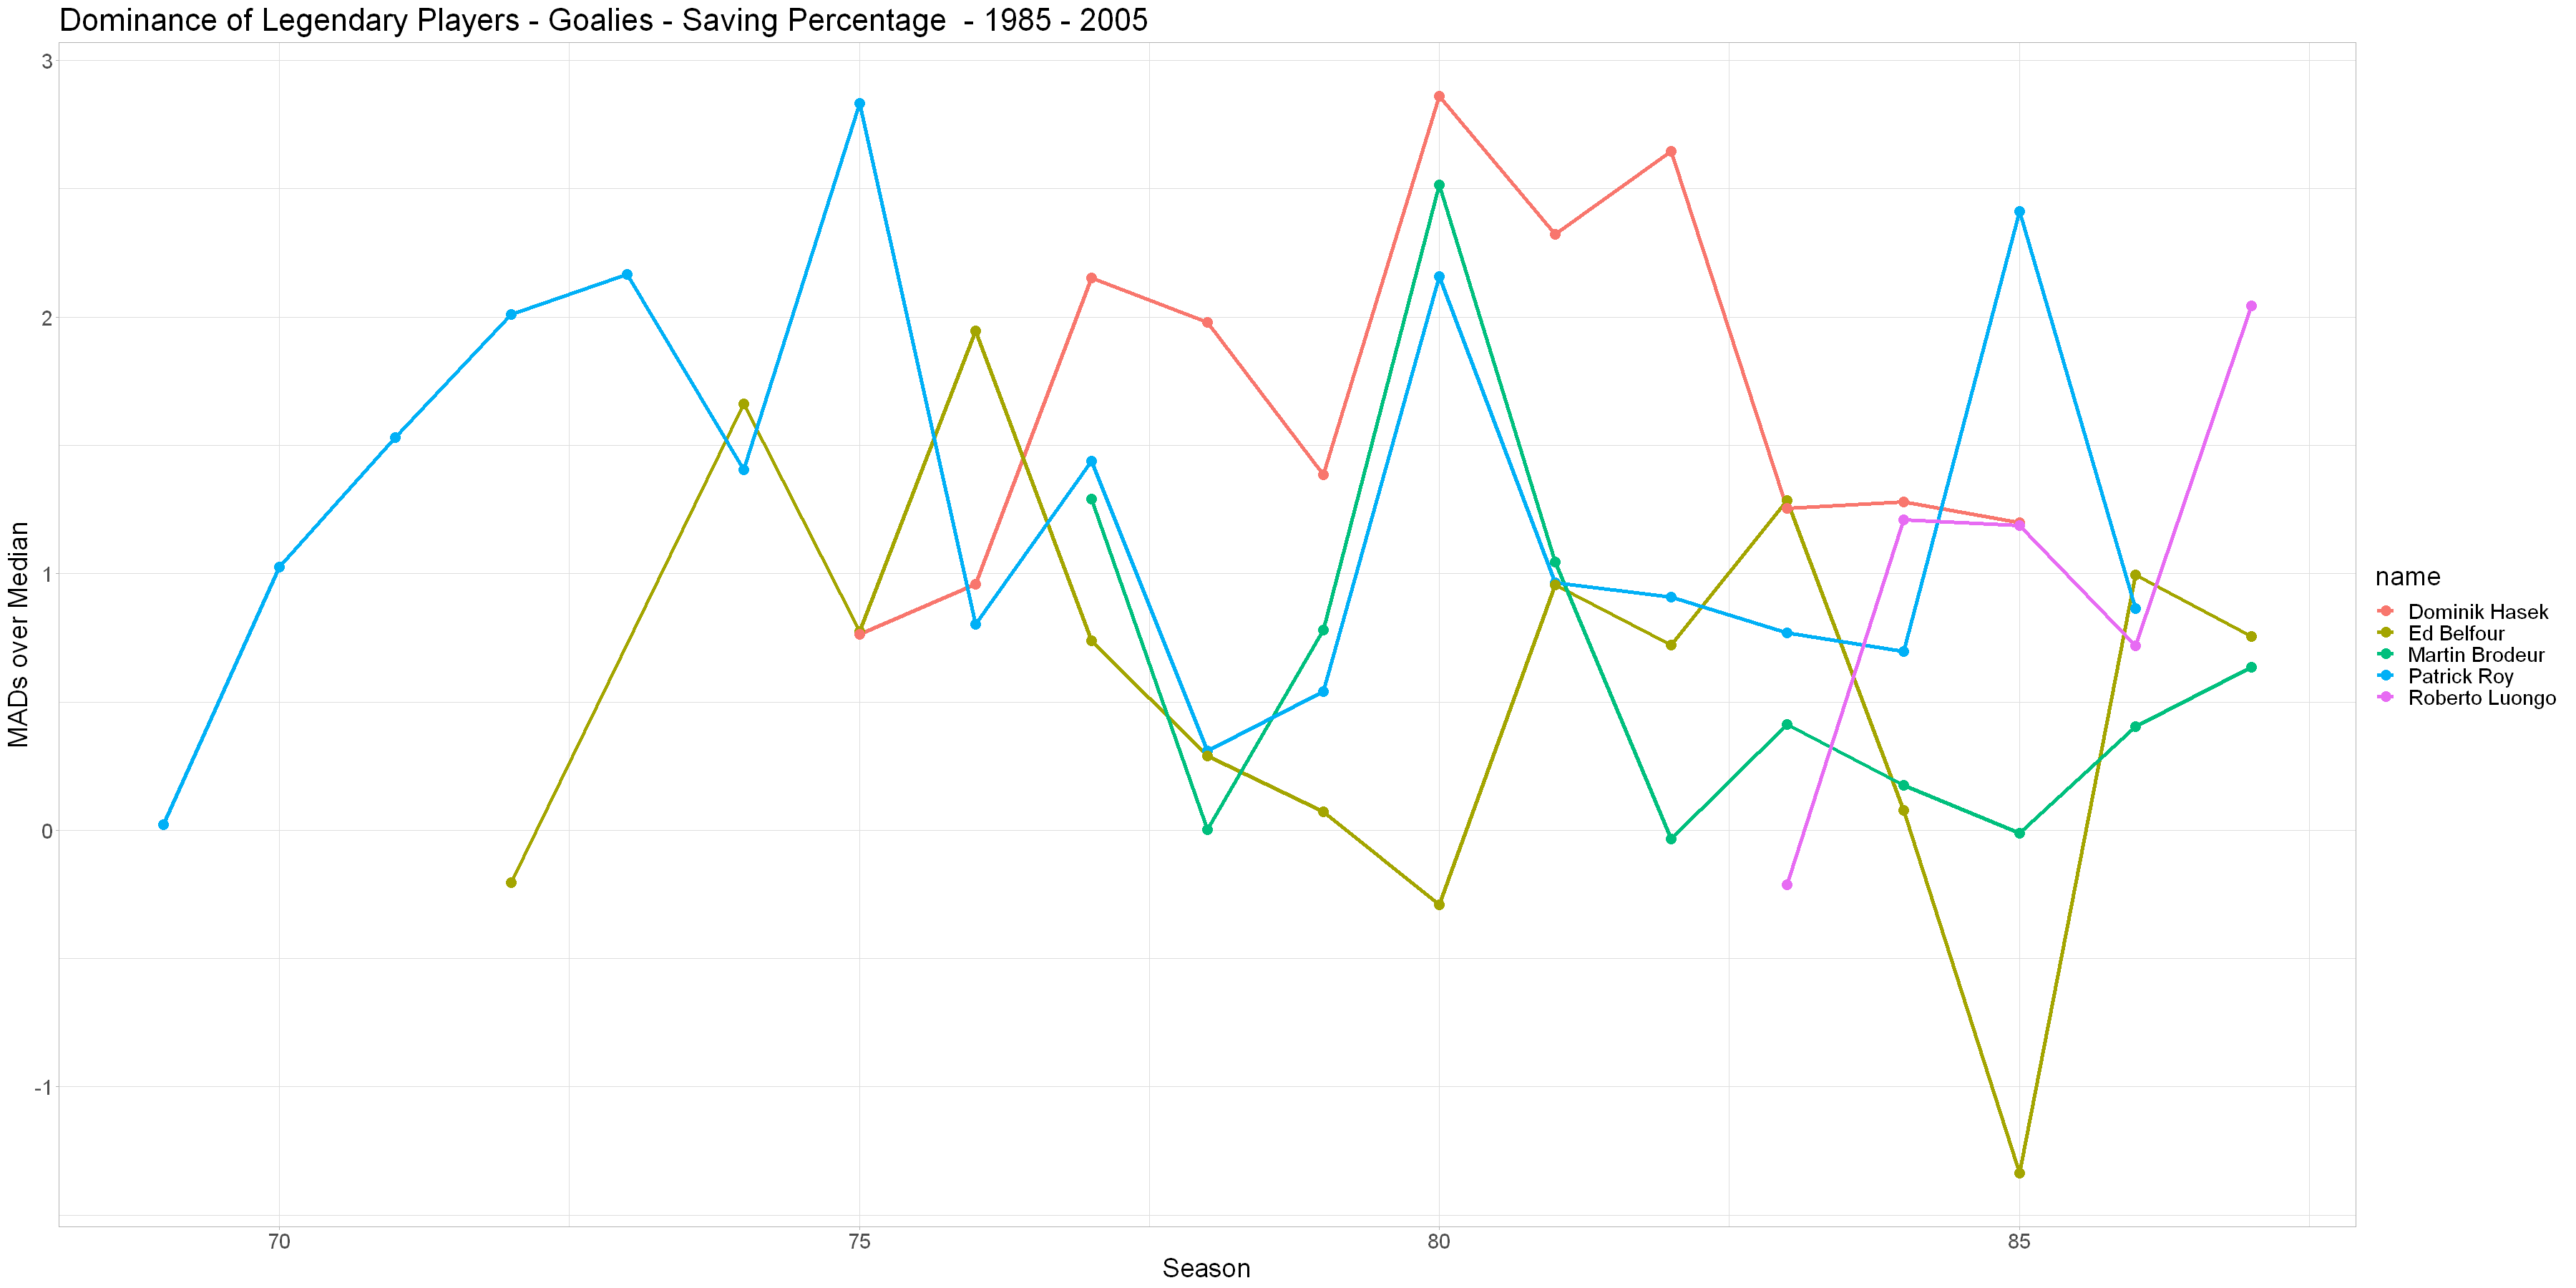

In [354]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id < 88 & season_id > 68) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1985 - 2005", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

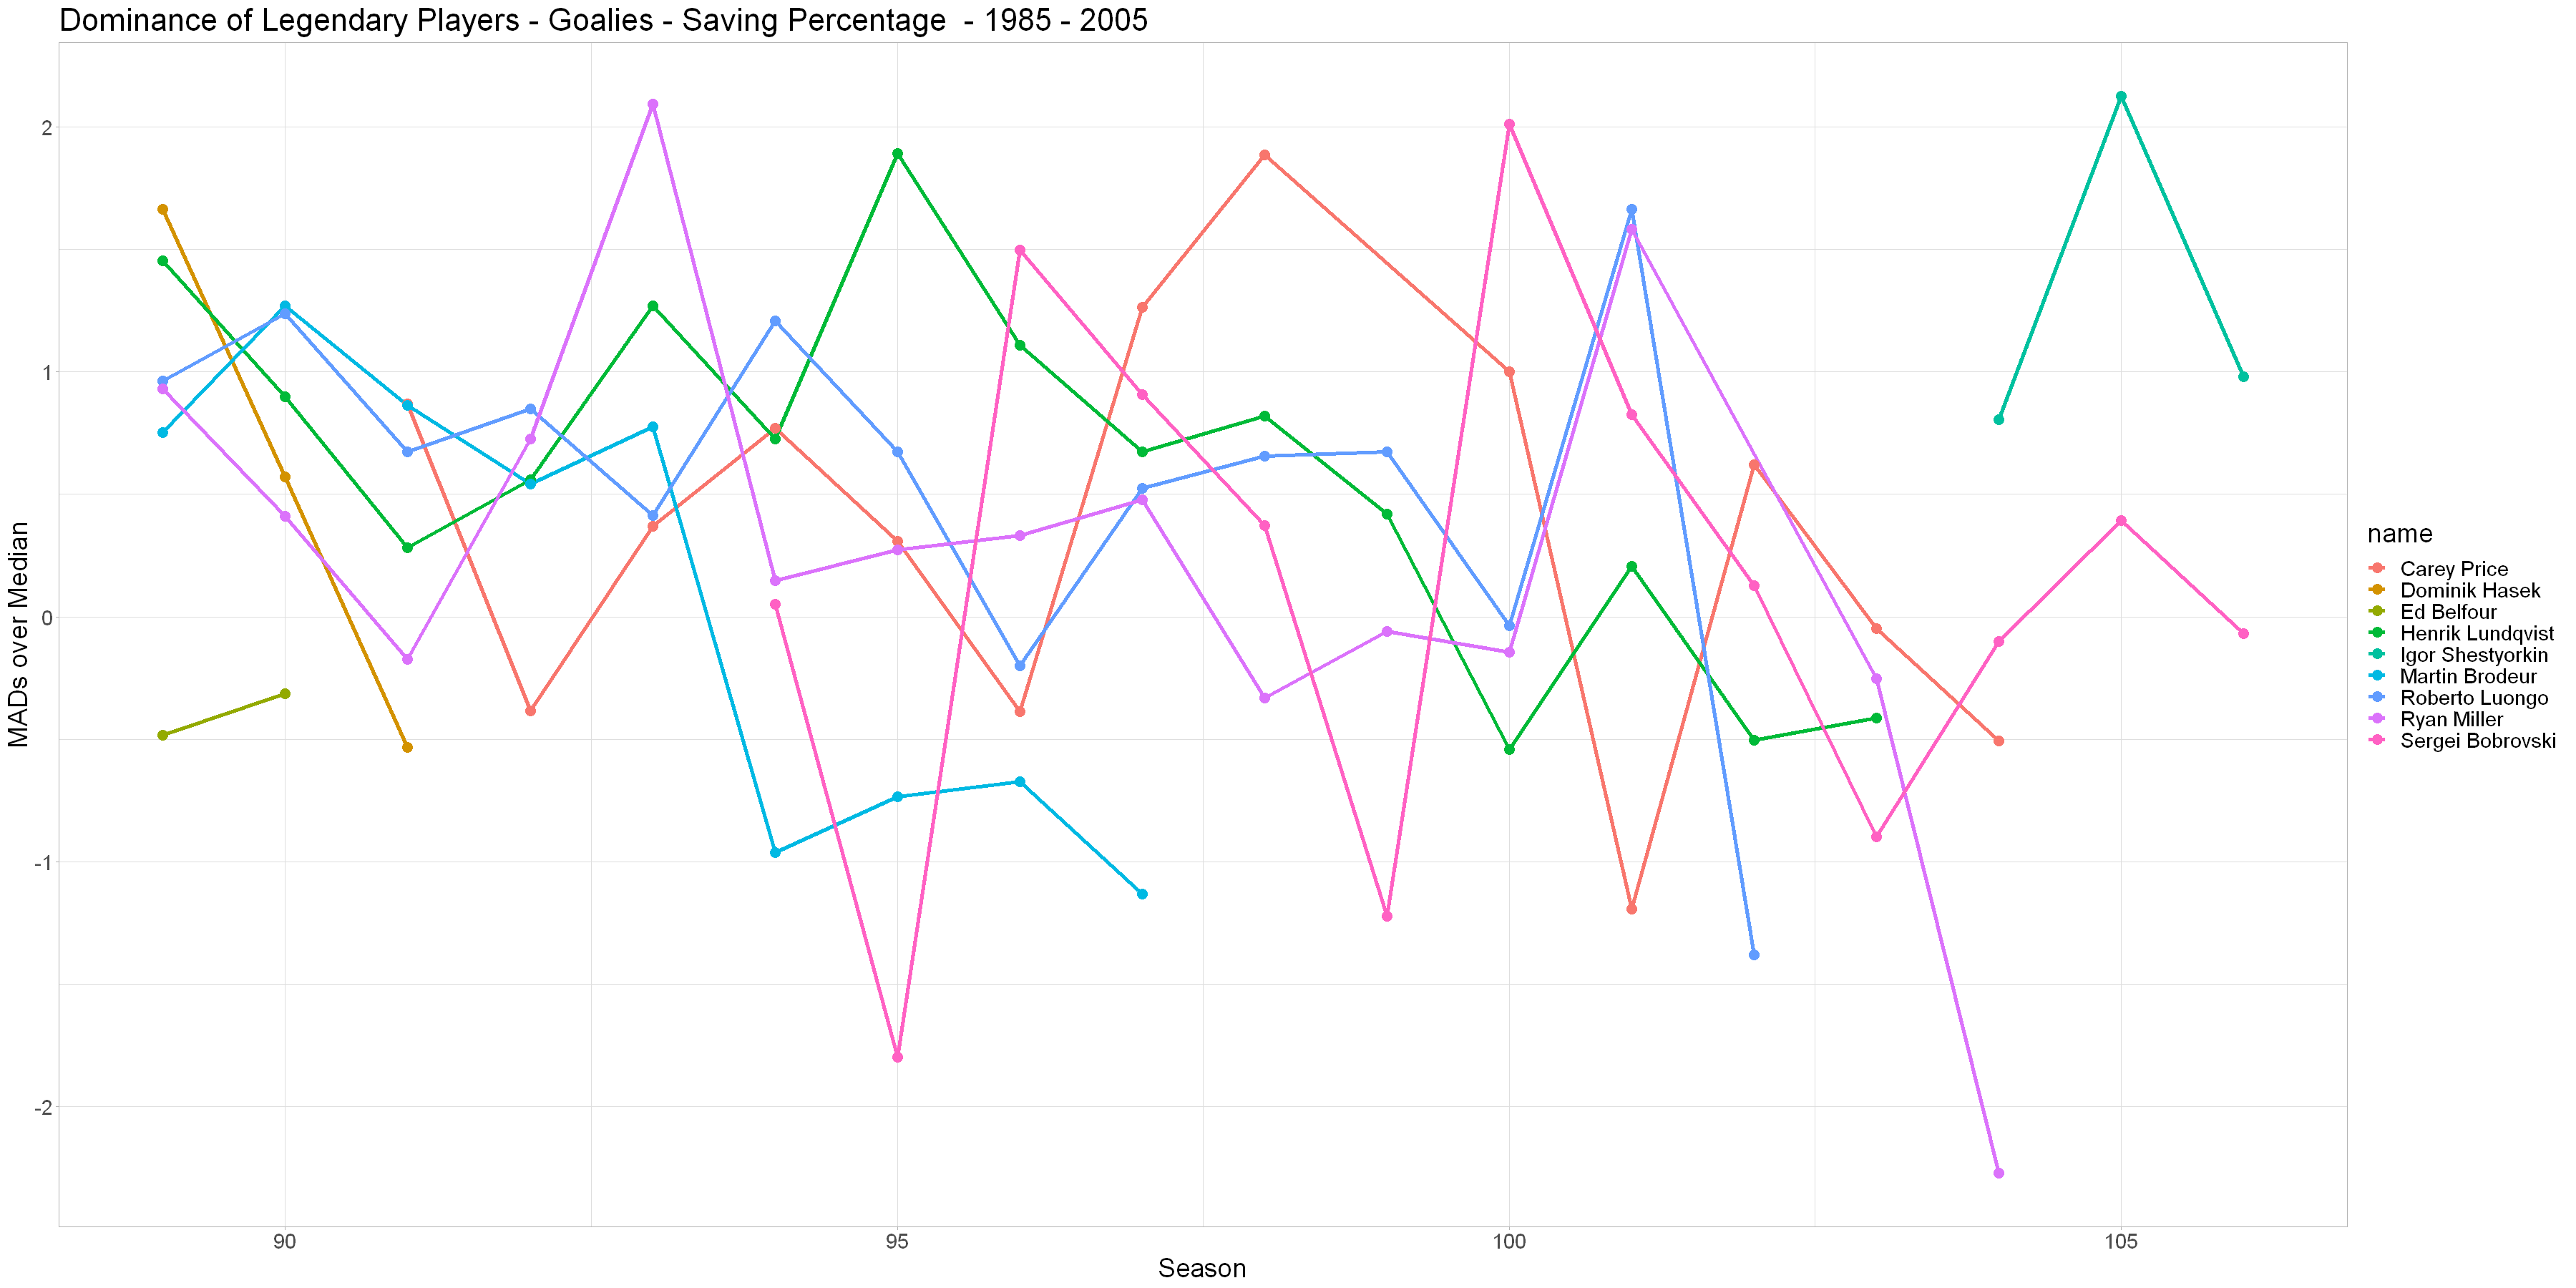

In [360]:
options(repr.plot.width = 30, repr.plot.height = 15)
goalie_legends <- c("Dominik Hasek", "Patrick Roy", "Tony Esposito", "Jacques Plante", 
"Henrik Lundqvist", "Martin Brodeur", "Ed Belfour", "Glenn Hall", "Johnny Bower", "Bernie Parent", 
"Ken Dryden", "Roberto Luongo", "Carey Price", "Sergei Bobrovski", "Ryan Miller", "Igor Shestyorkin")
dominance_svp %>%
  filter(name %in% goalie_legends) %>%
  filter(season_id > 88) %>%
  ggplot(., aes(x = season_id, y = measure, colour = name, group = name)) + 
  labs(
    title = "Dominance of Legendary Players - Goalies - Saving Percentage  - 1985 - 2005", 
    y = "MADs over Median", 
    x = "Season"
    ) + 
  geom_line(size = 1.5) + 
  geom_point(size = 4) + 
  def_plot_setup 

### 